# Evaluate a trained model

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import h5py
import os

import tensorflow as tf
import keras
import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

2024-07-07 12:19:09.662669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 12:19:09.662772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 12:19:09.772504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 12:19:10.038966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 12:19:11.661590: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("../../data/dataset_train.csv")
df["fullfilename"] = "../" + df["fullfilename"]

In [3]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = 32
    n_epochs = 50
    
    # class labels/names
    names = list(np.unique(df.en))
    n_classes = len(names)
    labels = list(range(n_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}


In [4]:
from tensorflow.keras.models import load_model

model = load_model('../models/Basemodel_test0.h5')
model.summary()

2024-07-07 12:19:15.690628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 12:19:16.035714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 12:19:16.036324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 12:19:16.038742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-07 12:19:16.039391: I external/local_xla/xla/stream_executor

Model: "Basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 162, 1)]     0         
                                                                 
 z_score_min_max (ZScoreMin  (None, 128, 162, 1)       0         
 Max)                                                            
                                                                 
 conv2d (Conv2D)             (None, 126, 160, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 80, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 78, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 39, 64)        0 

In [5]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

def load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None):
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

def pad_spectrogram(spec, shape = cfg.input_dim, random = False):
    _ = np.zeros(shape)
    if random:
        rdm = random_int(maxval=shape[1]-spec.shape[1])
        _[:,rdm: rdm + spec.shape[1]] = spec 
    else:
        _[:,:spec.shape[1]] = spec
    return _

def predict_file(df, ID, model):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    spec = load_spectrogram_slice(hdf5_path, name)
    slices = []
    
    for i in range(spec_length//cfg.input_dim[1]):
        slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
    if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration:
        # consider last slice, only if it is longer than the shortest clips in the dataset 
        slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
    
    preds = model.predict(np.expand_dims(np.array(slices), axis = -1))
    
    return np.mean(preds, axis = 0) # return mean prediction

def upsample_data(df, thr=200):
    # get the class distribution
    class_dist = df['en'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("en==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=cfg.seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

def downsample_data(df, thr=400):
    # get the class distribution
    class_dist = df['en'].value_counts()
    
    # identify the classes that have less than the threshold number of samples
    up_classes = class_dist[class_dist > thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    down_dfs = []

    # loop through the undersampled classes and upsample them
    for c in up_classes:
        # get the dataframe for the current class
        class_df = df.query("en==@c")
        # Remove that class data
        df = df.query("en!=@c")
        # upsample the dataframe
        class_df = class_df.sample(n=thr, replace=False, random_state=cfg.seed)
        # append the upsampled dataframe to the list
        down_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    down_df = pd.concat([df] + down_dfs, axis=0, ignore_index=True)
    
    return down_df

In [13]:
df = downsample_data(df, thr = 50)

In [18]:
predictions = []
for i in tqdm(df.index):
    predictions.append(predict_file(df, i, model))

  0%|                                                                                          | 0/2300 [00:00<?, ?it/s]2024-07-05 23:22:01.656183: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-05 23:22:02.828337: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-05 23:22:03.212781: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


  0%|                                                                                | 1/2300 [00:02<1:54:33,  2.99s/it]

1/1 [==============================] - 0s 229ms/step


  0%|                                                                                  | 2/2300 [00:03<55:15,  1.44s/it]

1/1 [==============================] - 0s 265ms/step


  0%|                                                                                  | 3/2300 [00:03<37:46,  1.01it/s]

1/1 [==============================] - 0s 264ms/step


  0%|▏                                                                                 | 4/2300 [00:04<29:31,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


  0%|▏                                                                                 | 5/2300 [00:04<20:44,  1.84it/s]

1/1 [==============================] - 0s 21ms/step


  0%|▏                                                                                 | 6/2300 [00:04<15:14,  2.51it/s]

1/1 [==============================] - 0s 300ms/step


  0%|▏                                                                                 | 7/2300 [00:04<15:44,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


  0%|▎                                                                                 | 8/2300 [00:05<11:59,  3.19it/s]

1/1 [==============================] - 0s 19ms/step


  0%|▎                                                                                 | 9/2300 [00:05<10:00,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


  0%|▍                                                                                | 11/2300 [00:05<07:05,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▍                                                                                | 12/2300 [00:05<06:37,  5.76it/s]

1/1 [==============================] - 0s 277ms/step


  1%|▍                                                                                | 13/2300 [00:05<08:47,  4.34it/s]

1/1 [==============================] - 0s 254ms/step


  1%|▍                                                                                | 14/2300 [00:06<09:53,  3.85it/s]

1/1 [==============================] - 0s 248ms/step


  1%|▌                                                                                | 15/2300 [00:06<10:58,  3.47it/s]

1/1 [==============================] - 0s 311ms/step


  1%|▌                                                                                | 16/2300 [00:07<12:33,  3.03it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▌                                                                                | 17/2300 [00:07<10:22,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▋                                                                                | 18/2300 [00:07<08:55,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▋                                                                                | 19/2300 [00:07<08:18,  4.57it/s]

1/1 [==============================] - 0s 252ms/step


  1%|▋                                                                                | 20/2300 [00:07<09:47,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▋                                                                                | 21/2300 [00:07<08:14,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▊                                                                                | 22/2300 [00:08<07:20,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▊                                                                                | 23/2300 [00:08<06:55,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▊                                                                                | 24/2300 [00:08<06:16,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▉                                                                                | 25/2300 [00:08<06:13,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▉                                                                                | 26/2300 [00:08<05:55,  6.40it/s]

1/1 [==============================] - 0s 300ms/step


  1%|▉                                                                                | 27/2300 [00:09<09:11,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▉                                                                                | 28/2300 [00:09<07:43,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


  1%|█                                                                                | 29/2300 [00:09<06:39,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


  1%|█                                                                                | 30/2300 [00:09<06:06,  6.20it/s]

1/1 [==============================] - 0s 347ms/step


  1%|█                                                                                | 31/2300 [00:09<09:36,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  1%|█▏                                                                               | 32/2300 [00:10<08:12,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


  1%|█▏                                                                               | 33/2300 [00:10<07:35,  4.98it/s]

1/1 [==============================] - 0s 197ms/step


  1%|█▏                                                                               | 34/2300 [00:10<08:28,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▏                                                                               | 35/2300 [00:10<07:14,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▎                                                                               | 36/2300 [00:10<06:23,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▎                                                                               | 37/2300 [00:10<05:44,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▎                                                                               | 39/2300 [00:11<04:42,  8.00it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▍                                                                               | 41/2300 [00:11<04:37,  8.15it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▍                                                                               | 42/2300 [00:11<05:02,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▌                                                                               | 43/2300 [00:11<05:05,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▌                                                                               | 44/2300 [00:11<05:01,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▌                                                                               | 45/2300 [00:11<05:59,  6.26it/s]

1/1 [==============================] - 0s 323ms/step


  2%|█▌                                                                               | 46/2300 [00:12<09:32,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▋                                                                               | 47/2300 [00:12<08:04,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


  2%|█▋                                                                               | 48/2300 [00:12<06:58,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▋                                                                               | 49/2300 [00:12<06:11,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▊                                                                               | 50/2300 [00:12<05:33,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▊                                                                               | 51/2300 [00:13<06:48,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▊                                                                               | 52/2300 [00:13<06:07,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▉                                                                               | 54/2300 [00:13<05:32,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▉                                                                               | 55/2300 [00:13<05:39,  6.61it/s]

1/1 [==============================] - 0s 20ms/step


  2%|█▉                                                                               | 56/2300 [00:13<05:34,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


  2%|██                                                                               | 57/2300 [00:14<05:26,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


  3%|██                                                                               | 59/2300 [00:14<04:50,  7.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▏                                                                              | 61/2300 [00:14<04:35,  8.13it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▏                                                                              | 62/2300 [00:14<04:36,  8.10it/s]

1/1 [==============================] - 0s 19ms/step


  3%|██▏                                                                              | 63/2300 [00:14<04:41,  7.95it/s]

1/1 [==============================] - 0s 19ms/step


  3%|██▎                                                                              | 64/2300 [00:14<04:37,  8.06it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▎                                                                              | 66/2300 [00:15<04:24,  8.46it/s]

1/1 [==============================] - 0s 452ms/step


  3%|██▎                                                                              | 67/2300 [00:15<08:16,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▍                                                                              | 68/2300 [00:15<07:25,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▍                                                                              | 69/2300 [00:15<06:27,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▍                                                                              | 70/2300 [00:16<06:18,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▌                                                                              | 72/2300 [00:16<05:16,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▌                                                                              | 73/2300 [00:16<04:59,  7.44it/s]

1/1 [==============================] - 0s 331ms/step


  3%|██▌                                                                              | 74/2300 [00:16<07:54,  4.69it/s]

1/1 [==============================] - 0s 23ms/step


  3%|██▋                                                                              | 75/2300 [00:16<07:00,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▋                                                                              | 77/2300 [00:17<05:22,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  3%|██▋                                                                              | 78/2300 [00:17<05:18,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▊                                                                              | 79/2300 [00:17<05:20,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


  3%|██▊                                                                              | 80/2300 [00:17<04:59,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


  4%|██▉                                                                              | 82/2300 [00:17<04:28,  8.26it/s]

1/1 [==============================] - 0s 360ms/step


  4%|██▉                                                                              | 83/2300 [00:18<07:09,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▉                                                                              | 84/2300 [00:18<06:47,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


  4%|███                                                                              | 86/2300 [00:18<05:28,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


  4%|███                                                                              | 87/2300 [00:18<05:19,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


  4%|███                                                                              | 88/2300 [00:18<04:57,  7.44it/s]

1/1 [==============================] - 0s 23ms/step


  4%|███▏                                                                             | 90/2300 [00:18<04:44,  7.76it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▏                                                                             | 92/2300 [00:19<04:19,  8.52it/s]

1/1 [==============================] - 0s 19ms/step


  4%|███▎                                                                             | 93/2300 [00:19<04:19,  8.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|███▎                                                                             | 94/2300 [00:19<04:27,  8.24it/s]

1/1 [==============================] - 0s 20ms/step


  4%|███▎                                                                             | 95/2300 [00:19<04:18,  8.52it/s]

1/1 [==============================] - 0s 22ms/step


  4%|███▍                                                                             | 96/2300 [00:19<04:12,  8.72it/s]

1/1 [==============================] - 0s 252ms/step


  4%|███▍                                                                             | 98/2300 [00:20<05:50,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


  4%|███▍                                                                             | 99/2300 [00:20<05:38,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|███▍                                                                            | 100/2300 [00:20<05:36,  6.54it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▌                                                                            | 101/2300 [00:20<06:18,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▌                                                                            | 102/2300 [00:20<05:38,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


  4%|███▌                                                                            | 103/2300 [00:20<05:04,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


  5%|███▌                                                                            | 104/2300 [00:20<05:17,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▋                                                                            | 105/2300 [00:21<05:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  5%|███▋                                                                            | 106/2300 [00:21<04:51,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▋                                                                            | 107/2300 [00:21<04:36,  7.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▊                                                                            | 109/2300 [00:21<04:18,  8.47it/s]

1/1 [==============================] - 0s 22ms/step


  5%|███▊                                                                            | 110/2300 [00:21<04:32,  8.05it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▊                                                                            | 111/2300 [00:21<04:30,  8.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▉                                                                            | 112/2300 [00:21<04:23,  8.30it/s]

1/1 [==============================] - 0s 23ms/step


  5%|███▉                                                                            | 113/2300 [00:21<04:30,  8.10it/s]

1/1 [==============================] - 0s 21ms/step


  5%|███▉                                                                            | 114/2300 [00:22<04:23,  8.30it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████                                                                            | 115/2300 [00:22<04:29,  8.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████                                                                            | 116/2300 [00:22<04:21,  8.34it/s]

1/1 [==============================] - 0s 19ms/step


  5%|████                                                                            | 118/2300 [00:22<04:09,  8.74it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████▏                                                                           | 120/2300 [00:22<04:07,  8.79it/s]

1/1 [==============================] - 0s 23ms/step


  5%|████▏                                                                           | 122/2300 [00:23<04:33,  7.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|████▎                                                                           | 123/2300 [00:23<04:33,  7.95it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████▎                                                                           | 124/2300 [00:23<04:40,  7.75it/s]

1/1 [==============================] - 0s 23ms/step


  5%|████▎                                                                           | 125/2300 [00:23<04:29,  8.06it/s]

1/1 [==============================] - 0s 18ms/step


  6%|████▍                                                                           | 127/2300 [00:23<04:46,  7.59it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▍                                                                           | 128/2300 [00:23<04:51,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▍                                                                           | 129/2300 [00:24<04:52,  7.43it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▌                                                                           | 131/2300 [00:24<05:00,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


  6%|████▋                                                                           | 133/2300 [00:24<04:20,  8.30it/s]

1/1 [==============================] - 0s 26ms/step


  6%|████▋                                                                           | 134/2300 [00:24<04:25,  8.17it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▋                                                                           | 135/2300 [00:24<04:30,  8.02it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▋                                                                           | 136/2300 [00:24<04:22,  8.25it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▊                                                                           | 137/2300 [00:25<04:45,  7.57it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▊                                                                           | 138/2300 [00:25<04:42,  7.64it/s]

1/1 [==============================] - 0s 24ms/step


  6%|████▊                                                                           | 139/2300 [00:25<05:09,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▊                                                                           | 140/2300 [00:25<04:48,  7.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|████▉                                                                           | 141/2300 [00:25<05:16,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


  6%|████▉                                                                           | 143/2300 [00:25<05:14,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


  6%|█████                                                                           | 144/2300 [00:26<04:59,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


  6%|█████                                                                           | 145/2300 [00:26<05:21,  6.69it/s]

1/1 [==============================] - 0s 23ms/step


  6%|█████                                                                           | 146/2300 [00:26<05:02,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


  6%|█████                                                                           | 147/2300 [00:26<04:42,  7.63it/s]

1/1 [==============================] - 0s 22ms/step


  6%|█████▏                                                                          | 148/2300 [00:26<06:19,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


  6%|█████▏                                                                          | 149/2300 [00:26<05:53,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▏                                                                          | 150/2300 [00:26<05:17,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▎                                                                          | 151/2300 [00:27<06:43,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▎                                                                          | 152/2300 [00:27<06:16,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▎                                                                          | 154/2300 [00:27<04:56,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▍                                                                          | 155/2300 [00:27<05:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▍                                                                          | 156/2300 [00:27<04:46,  7.49it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▍                                                                          | 157/2300 [00:27<04:57,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  7%|█████▍                                                                          | 158/2300 [00:28<04:49,  7.39it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▌                                                                          | 159/2300 [00:28<04:58,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▌                                                                          | 160/2300 [00:28<05:10,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▌                                                                          | 161/2300 [00:28<05:33,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                          | 162/2300 [00:28<05:20,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                          | 163/2300 [00:28<05:04,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▋                                                                          | 164/2300 [00:29<05:06,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


  7%|█████▋                                                                          | 165/2300 [00:29<04:52,  7.29it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▊                                                                          | 166/2300 [00:29<04:41,  7.57it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▊                                                                          | 167/2300 [00:29<05:17,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▊                                                                          | 168/2300 [00:29<05:28,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▉                                                                          | 169/2300 [00:29<05:06,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▉                                                                          | 170/2300 [00:29<05:12,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


  7%|█████▉                                                                          | 171/2300 [00:30<05:03,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


  7%|█████▉                                                                          | 172/2300 [00:30<06:07,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


  8%|██████                                                                          | 173/2300 [00:30<05:53,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████                                                                          | 174/2300 [00:30<05:12,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████                                                                          | 176/2300 [00:30<04:28,  7.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▏                                                                         | 177/2300 [00:30<04:47,  7.38it/s]

1/1 [==============================] - 0s 23ms/step


  8%|██████▏                                                                         | 178/2300 [00:31<04:46,  7.41it/s]

1/1 [==============================] - 0s 24ms/step


  8%|██████▏                                                                         | 179/2300 [00:31<04:41,  7.53it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▎                                                                         | 180/2300 [00:31<04:49,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▎                                                                         | 181/2300 [00:31<04:44,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▎                                                                         | 182/2300 [00:31<04:58,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▎                                                                         | 183/2300 [00:31<04:47,  7.35it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▍                                                                         | 184/2300 [00:31<04:42,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|██████▍                                                                         | 185/2300 [00:32<05:15,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


  8%|██████▍                                                                         | 186/2300 [00:32<04:56,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


  8%|██████▌                                                                         | 187/2300 [00:32<04:50,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▌                                                                         | 188/2300 [00:32<04:30,  7.80it/s]

1/1 [==============================] - 0s 25ms/step


  8%|██████▌                                                                         | 189/2300 [00:32<04:34,  7.69it/s]

1/1 [==============================] - 0s 25ms/step


  8%|██████▌                                                                         | 190/2300 [00:32<04:35,  7.66it/s]

1/1 [==============================] - 0s 24ms/step


  8%|██████▋                                                                         | 191/2300 [00:32<04:50,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


  8%|██████▋                                                                         | 192/2300 [00:32<04:38,  7.57it/s]

1/1 [==============================] - 0s 25ms/step


  8%|██████▋                                                                         | 193/2300 [00:33<05:27,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  8%|██████▋                                                                         | 194/2300 [00:33<05:23,  6.52it/s]

1/1 [==============================] - 0s 26ms/step


  8%|██████▊                                                                         | 195/2300 [00:33<05:41,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


  9%|██████▊                                                                         | 196/2300 [00:33<06:17,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


  9%|██████▊                                                                         | 197/2300 [00:33<05:34,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


  9%|██████▉                                                                         | 198/2300 [00:33<05:15,  6.65it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▉                                                                         | 199/2300 [00:34<05:12,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


  9%|██████▉                                                                         | 200/2300 [00:34<04:44,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


  9%|██████▉                                                                         | 201/2300 [00:34<05:52,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████                                                                         | 202/2300 [00:34<05:56,  5.88it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███████                                                                         | 203/2300 [00:34<05:45,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


  9%|███████                                                                         | 204/2300 [00:34<05:45,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███████▏                                                                        | 205/2300 [00:35<05:46,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▏                                                                        | 206/2300 [00:35<05:26,  6.41it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▏                                                                        | 207/2300 [00:35<05:20,  6.52it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▏                                                                        | 208/2300 [00:35<04:57,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███████▎                                                                        | 209/2300 [00:35<05:03,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▎                                                                        | 210/2300 [00:35<04:47,  7.28it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▎                                                                        | 211/2300 [00:35<04:27,  7.80it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▎                                                                        | 212/2300 [00:36<04:59,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▍                                                                        | 213/2300 [00:36<04:41,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▍                                                                        | 214/2300 [00:36<04:36,  7.54it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▍                                                                        | 215/2300 [00:36<04:46,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▌                                                                        | 216/2300 [00:36<04:55,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                        | 217/2300 [00:36<04:41,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


  9%|███████▌                                                                        | 218/2300 [00:36<04:43,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 10%|███████▌                                                                        | 219/2300 [00:37<05:33,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


 10%|███████▋                                                                        | 220/2300 [00:37<05:21,  6.46it/s]

1/1 [==============================] - 0s 22ms/step


 10%|███████▋                                                                        | 221/2300 [00:37<05:31,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 10%|███████▋                                                                        | 222/2300 [00:37<05:01,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 10%|███████▊                                                                        | 223/2300 [00:37<04:40,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 10%|███████▊                                                                        | 224/2300 [00:37<04:24,  7.86it/s]

1/1 [==============================] - 0s 22ms/step


 10%|███████▊                                                                        | 225/2300 [00:37<04:14,  8.15it/s]

1/1 [==============================] - 0s 23ms/step


 10%|███████▊                                                                        | 226/2300 [00:37<04:15,  8.10it/s]

1/1 [==============================] - 0s 19ms/step


 10%|███████▉                                                                        | 227/2300 [00:38<04:28,  7.73it/s]

1/1 [==============================] - 0s 20ms/step


 10%|███████▉                                                                        | 228/2300 [00:38<04:44,  7.28it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███████▉                                                                        | 229/2300 [00:38<04:46,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 10%|████████                                                                        | 230/2300 [00:38<05:38,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████████                                                                        | 231/2300 [00:38<05:22,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


 10%|████████                                                                        | 232/2300 [00:38<05:29,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████████                                                                        | 233/2300 [00:39<05:53,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 10%|████████▏                                                                       | 234/2300 [00:39<05:15,  6.55it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▏                                                                       | 235/2300 [00:39<05:10,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 10%|████████▏                                                                       | 236/2300 [00:39<04:49,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▏                                                                       | 237/2300 [00:39<04:54,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▎                                                                       | 238/2300 [00:39<04:58,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|████████▎                                                                       | 239/2300 [00:39<04:59,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|████████▎                                                                       | 240/2300 [00:40<04:53,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 10%|████████▍                                                                       | 241/2300 [00:40<04:40,  7.35it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▍                                                                       | 242/2300 [00:40<04:26,  7.72it/s]

1/1 [==============================] - 0s 24ms/step


 11%|████████▍                                                                       | 243/2300 [00:40<04:39,  7.37it/s]

1/1 [==============================] - 0s 23ms/step


 11%|████████▍                                                                       | 244/2300 [00:40<04:47,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▌                                                                       | 245/2300 [00:40<04:59,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


 11%|████████▌                                                                       | 247/2300 [00:41<05:31,  6.19it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▋                                                                       | 248/2300 [00:41<05:13,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


 11%|████████▋                                                                       | 249/2300 [00:41<04:56,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 11%|████████▋                                                                       | 250/2300 [00:41<05:10,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▋                                                                       | 251/2300 [00:41<07:05,  4.82it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▊                                                                       | 252/2300 [00:41<06:17,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▊                                                                       | 253/2300 [00:42<05:35,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 11%|████████▊                                                                       | 254/2300 [00:42<06:06,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 11%|████████▊                                                                       | 255/2300 [00:42<05:55,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 11%|████████▉                                                                       | 256/2300 [00:42<05:40,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 11%|████████▉                                                                       | 257/2300 [00:42<05:29,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


 11%|████████▉                                                                       | 258/2300 [00:42<05:02,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████                                                                       | 259/2300 [00:42<04:41,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████                                                                       | 260/2300 [00:43<04:49,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█████████                                                                       | 261/2300 [00:43<04:49,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████                                                                       | 262/2300 [00:43<04:50,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█████████▏                                                                      | 263/2300 [00:43<05:16,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█████████▏                                                                      | 264/2300 [00:43<05:03,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████████▏                                                                      | 265/2300 [00:43<04:49,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▎                                                                      | 266/2300 [00:44<05:02,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████████▎                                                                      | 268/2300 [00:44<04:22,  7.74it/s]

1/1 [==============================] - 1s 511ms/step


 12%|█████████▎                                                                      | 269/2300 [00:44<08:43,  3.88it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▍                                                                      | 271/2300 [00:45<06:44,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████████▍                                                                      | 273/2300 [00:45<05:58,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▌                                                                      | 274/2300 [00:45<05:28,  6.16it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▌                                                                      | 275/2300 [00:45<05:00,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▌                                                                      | 276/2300 [00:45<04:43,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▋                                                                      | 277/2300 [00:45<04:48,  7.02it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█████████▋                                                                      | 278/2300 [00:45<04:27,  7.57it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████████▋                                                                      | 279/2300 [00:46<04:13,  7.96it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▋                                                                      | 280/2300 [00:46<04:32,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█████████▊                                                                      | 281/2300 [00:46<04:13,  7.96it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▊                                                                      | 282/2300 [00:46<04:21,  7.72it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▊                                                                      | 283/2300 [00:46<04:37,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▉                                                                      | 284/2300 [00:46<04:25,  7.60it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████████▉                                                                      | 285/2300 [00:46<04:45,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█████████▉                                                                      | 286/2300 [00:47<04:24,  7.61it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█████████▉                                                                      | 287/2300 [00:47<04:31,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████                                                                      | 288/2300 [00:47<04:29,  7.46it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████                                                                      | 289/2300 [00:47<04:23,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 13%|██████████                                                                      | 290/2300 [00:47<04:09,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████                                                                      | 291/2300 [00:47<04:10,  8.03it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▏                                                                     | 292/2300 [00:47<03:57,  8.45it/s]

1/1 [==============================] - 0s 25ms/step


 13%|██████████▏                                                                     | 293/2300 [00:47<04:31,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▏                                                                     | 294/2300 [00:48<04:29,  7.44it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▎                                                                     | 295/2300 [00:48<04:17,  7.80it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▎                                                                     | 296/2300 [00:48<04:20,  7.69it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▎                                                                     | 297/2300 [00:48<04:41,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▎                                                                     | 298/2300 [00:48<04:20,  7.68it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▍                                                                     | 299/2300 [00:48<04:14,  7.88it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▍                                                                     | 300/2300 [00:48<04:00,  8.33it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▍                                                                     | 301/2300 [00:49<05:16,  6.31it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▌                                                                     | 302/2300 [00:49<04:51,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▌                                                                     | 303/2300 [00:49<05:28,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 13%|██████████▌                                                                     | 304/2300 [00:49<05:22,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


 13%|██████████▌                                                                     | 305/2300 [00:49<04:49,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▋                                                                     | 306/2300 [00:49<04:42,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▋                                                                     | 307/2300 [00:49<04:20,  7.65it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▋                                                                     | 308/2300 [00:50<04:11,  7.91it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▋                                                                     | 309/2300 [00:50<04:13,  7.84it/s]

1/1 [==============================] - 0s 22ms/step


 13%|██████████▊                                                                     | 310/2300 [00:50<04:10,  7.93it/s]

1/1 [==============================] - 0s 23ms/step


 14%|██████████▊                                                                     | 311/2300 [00:50<04:12,  7.88it/s]

1/1 [==============================] - 0s 21ms/step


 14%|██████████▊                                                                     | 312/2300 [00:50<04:24,  7.52it/s]

1/1 [==============================] - 0s 23ms/step


 14%|██████████▉                                                                     | 314/2300 [00:50<03:54,  8.47it/s]

1/1 [==============================] - 0s 19ms/step


 14%|██████████▉                                                                     | 315/2300 [00:50<03:49,  8.65it/s]

1/1 [==============================] - 0s 22ms/step


 14%|██████████▉                                                                     | 316/2300 [00:50<03:42,  8.91it/s]

1/1 [==============================] - 0s 24ms/step


 14%|███████████                                                                     | 317/2300 [00:51<03:45,  8.77it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████                                                                     | 318/2300 [00:51<03:42,  8.92it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████                                                                     | 319/2300 [00:51<04:20,  7.60it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▏                                                                    | 320/2300 [00:51<04:03,  8.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████▏                                                                    | 321/2300 [00:51<04:10,  7.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▏                                                                    | 322/2300 [00:51<03:55,  8.40it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████▏                                                                    | 323/2300 [00:51<03:55,  8.39it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▎                                                                    | 324/2300 [00:51<04:01,  8.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████▎                                                                    | 326/2300 [00:52<03:44,  8.78it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████▎                                                                    | 327/2300 [00:52<03:46,  8.72it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▍                                                                    | 328/2300 [00:52<03:40,  8.94it/s]

1/1 [==============================] - 0s 23ms/step


 14%|███████████▍                                                                    | 330/2300 [00:52<04:33,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 14%|███████████▌                                                                    | 331/2300 [00:53<05:32,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▌                                                                    | 332/2300 [00:53<05:27,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 14%|███████████▌                                                                    | 333/2300 [00:53<06:21,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▌                                                                    | 334/2300 [00:53<05:49,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


 15%|███████████▋                                                                    | 335/2300 [00:53<05:07,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▋                                                                    | 336/2300 [00:53<04:41,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▋                                                                    | 337/2300 [00:53<04:41,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 15%|███████████▊                                                                    | 338/2300 [00:54<04:28,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 15%|███████████▊                                                                    | 339/2300 [00:54<04:21,  7.50it/s]

1/1 [==============================] - 0s 21ms/step


 15%|███████████▊                                                                    | 340/2300 [00:54<04:10,  7.82it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▉                                                                    | 342/2300 [00:54<03:50,  8.49it/s]

1/1 [==============================] - 0s 25ms/step


 15%|███████████▉                                                                    | 343/2300 [00:54<03:50,  8.50it/s]

1/1 [==============================] - 0s 20ms/step


 15%|███████████▉                                                                    | 344/2300 [00:54<04:19,  7.55it/s]

1/1 [==============================] - 0s 23ms/step


 15%|████████████                                                                    | 345/2300 [00:54<04:17,  7.60it/s]

1/1 [==============================] - 0s 22ms/step


 15%|████████████                                                                    | 346/2300 [00:55<04:08,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 15%|████████████                                                                    | 347/2300 [00:55<04:25,  7.35it/s]

1/1 [==============================] - 0s 22ms/step


 15%|████████████                                                                    | 348/2300 [00:55<04:29,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 15%|████████████▏                                                                   | 349/2300 [00:55<04:09,  7.82it/s]

1/1 [==============================] - 0s 20ms/step


 15%|████████████▏                                                                   | 350/2300 [00:55<04:18,  7.54it/s]

1/1 [==============================] - 0s 21ms/step


 15%|████████████▏                                                                   | 351/2300 [00:55<05:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


 15%|████████████▏                                                                   | 352/2300 [00:55<04:35,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 15%|████████████▎                                                                   | 353/2300 [00:56<04:52,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 15%|████████████▎                                                                   | 354/2300 [00:56<04:39,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


 15%|████████████▎                                                                   | 355/2300 [00:56<04:27,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▍                                                                   | 357/2300 [00:56<03:54,  8.27it/s]

1/1 [==============================] - 0s 25ms/step


 16%|████████████▍                                                                   | 358/2300 [00:56<04:00,  8.07it/s]

1/1 [==============================] - 0s 22ms/step


 16%|████████████▌                                                                   | 360/2300 [00:56<03:41,  8.77it/s]

1/1 [==============================] - 0s 22ms/step


 16%|████████████▌                                                                   | 361/2300 [00:57<03:57,  8.16it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▌                                                                   | 362/2300 [00:57<04:01,  8.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▋                                                                   | 363/2300 [00:57<03:49,  8.42it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▋                                                                   | 364/2300 [00:57<04:02,  8.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|████████████▋                                                                   | 365/2300 [00:57<03:58,  8.11it/s]

1/1 [==============================] - 0s 22ms/step


 16%|████████████▋                                                                   | 366/2300 [00:57<03:53,  8.27it/s]

1/1 [==============================] - 0s 20ms/step


 16%|████████████▊                                                                   | 368/2300 [00:57<03:24,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 16%|████████████▊                                                                   | 369/2300 [00:57<04:00,  8.04it/s]

1/1 [==============================] - 0s 22ms/step


 16%|████████████▉                                                                   | 371/2300 [00:58<03:29,  9.21it/s]

1/1 [==============================] - 0s 24ms/step


 16%|████████████▉                                                                   | 372/2300 [00:58<03:44,  8.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|████████████▉                                                                   | 373/2300 [00:58<04:02,  7.94it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█████████████                                                                   | 374/2300 [00:58<03:52,  8.30it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█████████████                                                                   | 376/2300 [00:58<03:52,  8.26it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█████████████                                                                   | 377/2300 [00:58<04:02,  7.94it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█████████████▏                                                                  | 379/2300 [00:59<03:34,  8.96it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█████████████▏                                                                  | 380/2300 [00:59<03:47,  8.44it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█████████████▎                                                                  | 381/2300 [00:59<03:42,  8.63it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█████████████▎                                                                  | 382/2300 [00:59<03:44,  8.53it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█████████████▎                                                                  | 383/2300 [00:59<04:24,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█████████████▍                                                                  | 385/2300 [00:59<03:57,  8.08it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▍                                                                  | 386/2300 [01:00<04:04,  7.82it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▍                                                                  | 387/2300 [01:00<04:02,  7.90it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▍                                                                  | 388/2300 [01:00<04:19,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█████████████▌                                                                  | 389/2300 [01:00<04:15,  7.48it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█████████████▌                                                                  | 390/2300 [01:00<04:30,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▌                                                                  | 391/2300 [01:00<04:07,  7.70it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▋                                                                  | 392/2300 [01:00<04:36,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▋                                                                  | 393/2300 [01:00<04:13,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▋                                                                  | 395/2300 [01:01<03:48,  8.34it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█████████████▊                                                                  | 396/2300 [01:01<03:40,  8.65it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▊                                                                  | 397/2300 [01:01<03:57,  8.01it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█████████████▊                                                                  | 398/2300 [01:01<04:18,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█████████████▉                                                                  | 399/2300 [01:01<04:03,  7.81it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█████████████▉                                                                  | 401/2300 [01:02<04:52,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█████████████▉                                                                  | 402/2300 [01:02<05:05,  6.21it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████                                                                  | 403/2300 [01:02<04:51,  6.51it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████                                                                  | 404/2300 [01:02<04:46,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████                                                                  | 405/2300 [01:02<04:34,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████                                                                  | 406/2300 [01:02<04:57,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▏                                                                 | 407/2300 [01:03<04:55,  6.41it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▏                                                                 | 408/2300 [01:03<04:37,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████▏                                                                 | 409/2300 [01:03<04:16,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▎                                                                 | 410/2300 [01:03<03:59,  7.89it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████▎                                                                 | 411/2300 [01:03<04:03,  7.75it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▎                                                                 | 412/2300 [01:03<04:35,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 18%|██████████████▎                                                                 | 413/2300 [01:03<04:48,  6.54it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████████████▍                                                                 | 414/2300 [01:03<04:27,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████▍                                                                 | 415/2300 [01:04<04:31,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 18%|██████████████▍                                                                 | 416/2300 [01:04<04:33,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▌                                                                 | 418/2300 [01:04<04:07,  7.60it/s]

1/1 [==============================] - 0s 25ms/step


 18%|██████████████▌                                                                 | 419/2300 [01:04<04:43,  6.63it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▌                                                                 | 420/2300 [01:04<04:44,  6.61it/s]

1/1 [==============================] - 0s 24ms/step


 18%|██████████████▋                                                                 | 421/2300 [01:04<04:25,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▋                                                                 | 422/2300 [01:05<04:21,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 18%|██████████████▋                                                                 | 423/2300 [01:05<04:02,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


 18%|██████████████▊                                                                 | 425/2300 [01:05<04:15,  7.33it/s]

1/1 [==============================] - 0s 49ms/step


 19%|██████████████▊                                                                 | 426/2300 [01:05<04:39,  6.69it/s]

1/1 [==============================] - 0s 45ms/step


 19%|██████████████▊                                                                 | 427/2300 [01:05<05:17,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▉                                                                 | 428/2300 [01:06<05:21,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▉                                                                 | 430/2300 [01:06<04:45,  6.55it/s]

1/1 [==============================] - 0s 22ms/step


 19%|██████████████▉                                                                 | 431/2300 [01:06<04:32,  6.85it/s]

1/1 [==============================] - 0s 29ms/step


 19%|███████████████                                                                 | 432/2300 [01:06<04:15,  7.32it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████████████                                                                 | 433/2300 [01:06<04:30,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████                                                                 | 434/2300 [01:06<04:33,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 19%|███████████████▏                                                                | 435/2300 [01:07<04:16,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████▏                                                                | 436/2300 [01:07<04:14,  7.32it/s]

1/1 [==============================] - 0s 22ms/step


 19%|███████████████▏                                                                | 437/2300 [01:07<04:10,  7.43it/s]

1/1 [==============================] - 0s 23ms/step


 19%|███████████████▏                                                                | 438/2300 [01:07<03:56,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████▎                                                                | 439/2300 [01:07<05:07,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


 19%|███████████████▎                                                                | 440/2300 [01:07<05:18,  5.85it/s]

1/1 [==============================] - 0s 47ms/step


 19%|███████████████▎                                                                | 441/2300 [01:08<06:13,  4.98it/s]

1/1 [==============================] - 0s 42ms/step


 19%|███████████████▎                                                                | 442/2300 [01:08<06:48,  4.55it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████████████▍                                                                | 443/2300 [01:08<06:37,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 19%|███████████████▍                                                                | 444/2300 [01:08<06:09,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 19%|███████████████▍                                                                | 445/2300 [01:08<05:37,  5.50it/s]

1/1 [==============================] - 0s 24ms/step


 19%|███████████████▌                                                                | 446/2300 [01:09<05:26,  5.67it/s]

1/1 [==============================] - 0s 24ms/step


 19%|███████████████▌                                                                | 447/2300 [01:09<05:20,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 19%|███████████████▌                                                                | 448/2300 [01:09<04:51,  6.36it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▌                                                                | 449/2300 [01:09<04:30,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████████████▋                                                                | 450/2300 [01:09<04:37,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


 20%|███████████████▋                                                                | 451/2300 [01:09<05:28,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 20%|███████████████▋                                                                | 452/2300 [01:10<05:18,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▊                                                                | 453/2300 [01:10<04:52,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


 20%|███████████████▊                                                                | 455/2300 [01:10<04:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 20%|███████████████▊                                                                | 456/2300 [01:10<03:58,  7.73it/s]

1/1 [==============================] - 0s 21ms/step


 20%|███████████████▉                                                                | 458/2300 [01:10<03:33,  8.63it/s]

1/1 [==============================] - 0s 20ms/step


 20%|████████████████                                                                | 460/2300 [01:10<03:18,  9.26it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████                                                                | 461/2300 [01:11<03:53,  7.87it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████                                                                | 462/2300 [01:11<03:48,  8.05it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████                                                                | 463/2300 [01:11<03:45,  8.15it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████▏                                                               | 464/2300 [01:11<03:58,  7.70it/s]

1/1 [==============================] - 0s 23ms/step


 20%|████████████████▏                                                               | 465/2300 [01:11<03:50,  7.95it/s]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▏                                                               | 466/2300 [01:11<04:04,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▏                                                               | 467/2300 [01:11<04:22,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 20%|████████████████▎                                                               | 468/2300 [01:11<04:10,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 20%|████████████████▎                                                               | 469/2300 [01:12<04:41,  6.50it/s]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████▎                                                               | 470/2300 [01:12<04:36,  6.62it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▍                                                               | 471/2300 [01:12<04:31,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▍                                                               | 472/2300 [01:12<04:26,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████████████▍                                                               | 473/2300 [01:12<04:04,  7.47it/s]

1/1 [==============================] - 0s 23ms/step


 21%|████████████████▍                                                               | 474/2300 [01:12<04:12,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████████████▌                                                               | 475/2300 [01:13<05:11,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▌                                                               | 476/2300 [01:13<04:47,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


 21%|████████████████▌                                                               | 477/2300 [01:13<04:34,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▋                                                               | 478/2300 [01:13<04:23,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▋                                                               | 479/2300 [01:13<04:14,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 21%|████████████████▋                                                               | 480/2300 [01:13<04:04,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 21%|████████████████▋                                                               | 481/2300 [01:13<03:46,  8.05it/s]

1/1 [==============================] - 0s 22ms/step


 21%|████████████████▊                                                               | 482/2300 [01:13<03:38,  8.31it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▊                                                               | 483/2300 [01:14<04:03,  7.45it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▊                                                               | 484/2300 [01:14<04:01,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 21%|████████████████▉                                                               | 486/2300 [01:14<03:36,  8.38it/s]

1/1 [==============================] - 0s 41ms/step


 21%|████████████████▉                                                               | 487/2300 [01:14<03:40,  8.22it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████████████▉                                                               | 488/2300 [01:14<03:45,  8.02it/s]

1/1 [==============================] - 0s 22ms/step


 21%|█████████████████                                                               | 489/2300 [01:14<03:34,  8.44it/s]

1/1 [==============================] - 0s 20ms/step


 21%|█████████████████                                                               | 490/2300 [01:14<03:28,  8.70it/s]

1/1 [==============================] - 0s 21ms/step


 21%|█████████████████                                                               | 491/2300 [01:15<03:22,  8.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|█████████████████                                                               | 492/2300 [01:15<03:22,  8.94it/s]

1/1 [==============================] - 0s 21ms/step


 21%|█████████████████▏                                                              | 493/2300 [01:15<03:31,  8.55it/s]

1/1 [==============================] - 0s 22ms/step


 21%|█████████████████▏                                                              | 494/2300 [01:15<03:26,  8.75it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▏                                                              | 495/2300 [01:15<03:26,  8.75it/s]

1/1 [==============================] - 0s 18ms/step


 22%|█████████████████▎                                                              | 496/2300 [01:15<03:35,  8.36it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▎                                                              | 497/2300 [01:15<03:35,  8.38it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▎                                                              | 498/2300 [01:15<03:39,  8.19it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▎                                                              | 499/2300 [01:16<03:56,  7.61it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████████████▍                                                              | 501/2300 [01:16<05:29,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▍                                                              | 502/2300 [01:16<05:58,  5.01it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▍                                                              | 503/2300 [01:16<05:57,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████████████▌                                                              | 504/2300 [01:17<05:24,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▌                                                              | 505/2300 [01:17<05:25,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▌                                                              | 506/2300 [01:17<05:14,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 22%|█████████████████▋                                                              | 507/2300 [01:17<05:04,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▋                                                              | 508/2300 [01:17<05:02,  5.92it/s]

1/1 [==============================] - 0s 23ms/step


 22%|█████████████████▋                                                              | 509/2300 [01:17<04:36,  6.48it/s]

1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▋                                                              | 510/2300 [01:18<05:17,  5.63it/s]

1/1 [==============================] - 0s 24ms/step


 22%|█████████████████▊                                                              | 511/2300 [01:18<06:17,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 22%|█████████████████▊                                                              | 512/2300 [01:18<05:26,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 22%|█████████████████▊                                                              | 513/2300 [01:18<05:14,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 22%|█████████████████▉                                                              | 514/2300 [01:18<05:20,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 22%|█████████████████▉                                                              | 515/2300 [01:19<05:21,  5.54it/s]

1/1 [==============================] - 0s 24ms/step


 22%|█████████████████▉                                                              | 516/2300 [01:19<05:11,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 22%|█████████████████▉                                                              | 517/2300 [01:19<05:18,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██████████████████                                                              | 518/2300 [01:19<04:53,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██████████████████                                                              | 519/2300 [01:19<04:48,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██████████████████                                                              | 520/2300 [01:19<05:08,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████                                                              | 521/2300 [01:20<06:43,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▏                                                             | 522/2300 [01:20<06:38,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▏                                                             | 523/2300 [01:20<05:44,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▏                                                             | 524/2300 [01:20<05:36,  5.27it/s]

1/1 [==============================] - 1s 644ms/step


 23%|██████████████████▎                                                             | 525/2300 [01:21<11:20,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██████████████████▎                                                             | 526/2300 [01:21<08:56,  3.31it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▎                                                             | 527/2300 [01:21<07:25,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▎                                                             | 528/2300 [01:22<06:43,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██████████████████▍                                                             | 529/2300 [01:22<05:35,  5.27it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██████████████████▍                                                             | 530/2300 [01:22<05:31,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▍                                                             | 531/2300 [01:22<04:54,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▌                                                             | 532/2300 [01:22<04:29,  6.55it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▌                                                             | 533/2300 [01:22<04:19,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▌                                                             | 534/2300 [01:22<04:56,  5.96it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██████████████████▌                                                             | 535/2300 [01:23<05:53,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▋                                                             | 536/2300 [01:23<05:15,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██████████████████▋                                                             | 537/2300 [01:23<04:51,  6.04it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                             | 538/2300 [01:23<05:01,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 539/2300 [01:23<05:00,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▊                                                             | 540/2300 [01:23<05:10,  5.67it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                             | 541/2300 [01:24<04:50,  6.06it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██████████████████▊                                                             | 542/2300 [01:24<04:40,  6.27it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▉                                                             | 543/2300 [01:24<04:43,  6.21it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██████████████████▉                                                             | 544/2300 [01:24<04:45,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██████████████████▉                                                             | 545/2300 [01:24<04:47,  6.10it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▉                                                             | 546/2300 [01:24<04:51,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 24%|███████████████████                                                             | 547/2300 [01:25<04:42,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


 24%|███████████████████                                                             | 548/2300 [01:25<04:11,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 24%|███████████████████                                                             | 549/2300 [01:25<04:31,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


 24%|███████████████████▏                                                            | 550/2300 [01:25<04:31,  6.46it/s]

1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▏                                                            | 551/2300 [01:25<04:49,  6.04it/s]

1/1 [==============================] - 0s 24ms/step


 24%|███████████████████▏                                                            | 552/2300 [01:25<04:39,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


 24%|███████████████████▏                                                            | 553/2300 [01:26<04:55,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 24%|███████████████████▎                                                            | 554/2300 [01:26<05:07,  5.67it/s]

1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▎                                                            | 555/2300 [01:26<04:42,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


 24%|███████████████████▎                                                            | 556/2300 [01:26<04:28,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▎                                                            | 557/2300 [01:26<04:07,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 24%|███████████████████▍                                                            | 558/2300 [01:26<03:49,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 24%|███████████████████▍                                                            | 559/2300 [01:26<04:32,  6.40it/s]

1/1 [==============================] - 0s 33ms/step


 24%|███████████████████▍                                                            | 560/2300 [01:27<04:49,  6.02it/s]

1/1 [==============================] - 0s 22ms/step


 24%|███████████████████▌                                                            | 561/2300 [01:27<05:02,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 24%|███████████████████▌                                                            | 562/2300 [01:27<04:36,  6.30it/s]

1/1 [==============================] - 0s 40ms/step


 24%|███████████████████▌                                                            | 563/2300 [01:27<04:22,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


 25%|███████████████████▌                                                            | 564/2300 [01:27<04:16,  6.76it/s]

1/1 [==============================] - 0s 50ms/step


 25%|███████████████████▋                                                            | 565/2300 [01:27<04:19,  6.68it/s]

1/1 [==============================] - 0s 50ms/step


 25%|███████████████████▋                                                            | 566/2300 [01:28<04:52,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▋                                                            | 567/2300 [01:28<05:17,  5.46it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▊                                                            | 568/2300 [01:28<05:15,  5.48it/s]

1/1 [==============================] - 0s 41ms/step


 25%|███████████████████▊                                                            | 569/2300 [01:28<05:09,  5.60it/s]

1/1 [==============================] - 0s 41ms/step


 25%|███████████████████▊                                                            | 570/2300 [01:28<05:40,  5.08it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████▊                                                            | 571/2300 [01:29<05:24,  5.33it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▉                                                            | 572/2300 [01:29<05:16,  5.47it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▉                                                            | 573/2300 [01:29<04:54,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 25%|███████████████████▉                                                            | 574/2300 [01:29<04:26,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████                                                            | 575/2300 [01:29<04:53,  5.89it/s]

1/1 [==============================] - 0s 22ms/step


 25%|████████████████████                                                            | 576/2300 [01:29<04:28,  6.42it/s]

1/1 [==============================] - 0s 38ms/step


 25%|████████████████████                                                            | 577/2300 [01:29<04:30,  6.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|████████████████████                                                            | 578/2300 [01:30<04:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▏                                                           | 579/2300 [01:30<03:43,  7.69it/s]

1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▏                                                           | 580/2300 [01:30<04:09,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 25%|████████████████████▏                                                           | 582/2300 [01:30<04:42,  6.08it/s]

1/1 [==============================] - 0s 25ms/step


 25%|████████████████████▎                                                           | 583/2300 [01:30<04:34,  6.26it/s]

1/1 [==============================] - 0s 18ms/step


 25%|████████████████████▎                                                           | 584/2300 [01:30<04:08,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 25%|████████████████████▍                                                           | 586/2300 [01:31<03:34,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▍                                                           | 587/2300 [01:31<03:32,  8.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▍                                                           | 588/2300 [01:31<03:38,  7.83it/s]

1/1 [==============================] - 0s 22ms/step


 26%|████████████████████▍                                                           | 589/2300 [01:31<03:30,  8.14it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▌                                                           | 590/2300 [01:31<03:20,  8.54it/s]

1/1 [==============================] - 0s 23ms/step


 26%|████████████████████▌                                                           | 591/2300 [01:31<04:06,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▌                                                           | 592/2300 [01:32<03:57,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▋                                                           | 594/2300 [01:32<03:42,  7.68it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▋                                                           | 596/2300 [01:32<03:26,  8.26it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▊                                                           | 598/2300 [01:32<03:03,  9.27it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▊                                                           | 599/2300 [01:32<03:18,  8.56it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▉                                                           | 601/2300 [01:33<03:39,  7.74it/s]

1/1 [==============================] - 0s 21ms/step


 26%|████████████████████▉                                                           | 603/2300 [01:33<03:43,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 26%|█████████████████████                                                           | 605/2300 [01:33<03:27,  8.17it/s]

1/1 [==============================] - 0s 21ms/step


 26%|█████████████████████                                                           | 606/2300 [01:33<03:28,  8.13it/s]

1/1 [==============================] - 0s 21ms/step


 26%|█████████████████████                                                           | 607/2300 [01:33<04:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|█████████████████████▏                                                          | 608/2300 [01:34<03:51,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 26%|█████████████████████▏                                                          | 609/2300 [01:34<03:38,  7.74it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▏                                                          | 610/2300 [01:34<03:42,  7.59it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▎                                                          | 611/2300 [01:34<03:54,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▎                                                          | 612/2300 [01:34<04:20,  6.48it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▎                                                          | 613/2300 [01:34<04:14,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▎                                                          | 614/2300 [01:34<03:54,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▍                                                          | 615/2300 [01:35<03:55,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▍                                                          | 616/2300 [01:35<03:58,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▍                                                          | 617/2300 [01:35<04:37,  6.07it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▍                                                          | 618/2300 [01:35<04:10,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▌                                                          | 620/2300 [01:35<03:45,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▌                                                          | 621/2300 [01:35<03:46,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 27%|█████████████████████▋                                                          | 622/2300 [01:36<04:05,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 27%|█████████████████████▋                                                          | 623/2300 [01:36<04:17,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▋                                                          | 624/2300 [01:36<03:54,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▋                                                          | 625/2300 [01:36<04:00,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▊                                                          | 626/2300 [01:36<04:30,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


 27%|█████████████████████▊                                                          | 627/2300 [01:36<04:09,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▉                                                          | 629/2300 [01:36<03:21,  8.28it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▉                                                          | 630/2300 [01:37<03:19,  8.37it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▉                                                          | 631/2300 [01:37<03:32,  7.86it/s]

1/1 [==============================] - 0s 21ms/step


 27%|█████████████████████▉                                                          | 632/2300 [01:37<03:56,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████                                                          | 633/2300 [01:37<03:49,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████                                                          | 634/2300 [01:37<03:43,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████                                                          | 636/2300 [01:37<03:06,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████▏                                                         | 637/2300 [01:37<03:11,  8.71it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▏                                                         | 639/2300 [01:38<02:53,  9.56it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████▎                                                         | 640/2300 [01:38<02:59,  9.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▎                                                         | 642/2300 [01:38<03:13,  8.56it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▎                                                         | 643/2300 [01:38<03:17,  8.38it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██████████████████████▍                                                         | 644/2300 [01:38<03:27,  7.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▍                                                         | 646/2300 [01:39<03:31,  7.83it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████▌                                                         | 648/2300 [01:39<03:17,  8.36it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██████████████████████▌                                                         | 649/2300 [01:39<03:36,  7.64it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██████████████████████▌                                                         | 650/2300 [01:39<03:32,  7.77it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████▋                                                         | 651/2300 [01:39<04:21,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████▋                                                         | 652/2300 [01:39<03:57,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██████████████████████▋                                                         | 653/2300 [01:40<04:00,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████▊                                                         | 655/2300 [01:40<03:35,  7.65it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██████████████████████▊                                                         | 657/2300 [01:40<03:12,  8.52it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██████████████████████▉                                                         | 659/2300 [01:40<03:03,  8.94it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██████████████████████▉                                                         | 660/2300 [01:40<03:07,  8.74it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██████████████████████▉                                                         | 661/2300 [01:40<03:31,  7.76it/s]

1/1 [==============================] - 0s 20ms/step


 29%|███████████████████████                                                         | 663/2300 [01:41<03:08,  8.69it/s]

1/1 [==============================] - 0s 20ms/step


 29%|███████████████████████                                                         | 664/2300 [01:41<03:06,  8.76it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████████████████▏                                                        | 665/2300 [01:41<03:03,  8.92it/s]

1/1 [==============================] - 0s 23ms/step


 29%|███████████████████████▏                                                        | 666/2300 [01:41<03:05,  8.81it/s]

1/1 [==============================] - 0s 19ms/step


 29%|███████████████████████▏                                                        | 668/2300 [01:41<03:07,  8.73it/s]

1/1 [==============================] - 0s 28ms/step


 29%|███████████████████████▎                                                        | 669/2300 [01:41<03:40,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|███████████████████████▎                                                        | 670/2300 [01:42<03:28,  7.81it/s]

1/1 [==============================] - 0s 21ms/step


 29%|███████████████████████▎                                                        | 671/2300 [01:42<03:17,  8.23it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████████████████▎                                                        | 672/2300 [01:42<03:58,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 29%|███████████████████████▍                                                        | 673/2300 [01:42<03:42,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 29%|███████████████████████▍                                                        | 674/2300 [01:42<04:03,  6.67it/s]

1/1 [==============================] - 0s 23ms/step


 29%|███████████████████████▍                                                        | 675/2300 [01:42<04:23,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


 29%|███████████████████████▌                                                        | 677/2300 [01:43<03:29,  7.75it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████████████████▌                                                        | 678/2300 [01:43<03:56,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███████████████████████▌                                                        | 679/2300 [01:43<03:37,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███████████████████████▋                                                        | 680/2300 [01:43<03:24,  7.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███████████████████████▋                                                        | 682/2300 [01:43<03:02,  8.86it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▊                                                        | 684/2300 [01:43<03:22,  7.97it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███████████████████████▊                                                        | 685/2300 [01:44<03:18,  8.15it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███████████████████████▊                                                        | 686/2300 [01:44<03:19,  8.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███████████████████████▉                                                        | 688/2300 [01:44<03:05,  8.68it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████                                                        | 690/2300 [01:44<02:54,  9.23it/s]

1/1 [==============================] - 0s 19ms/step


 30%|████████████████████████                                                        | 691/2300 [01:44<02:55,  9.15it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████                                                        | 692/2300 [01:44<03:02,  8.81it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████                                                        | 693/2300 [01:44<03:07,  8.58it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▏                                                       | 694/2300 [01:45<03:10,  8.45it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▏                                                       | 695/2300 [01:45<03:09,  8.47it/s]

1/1 [==============================] - 0s 20ms/step


 30%|████████████████████████▏                                                       | 697/2300 [01:45<03:01,  8.85it/s]

1/1 [==============================] - 0s 23ms/step


 30%|████████████████████████▎                                                       | 699/2300 [01:45<02:54,  9.17it/s]

1/1 [==============================] - 0s 21ms/step


 30%|████████████████████████▍                                                       | 701/2300 [01:45<03:27,  7.72it/s]

1/1 [==============================] - 0s 19ms/step


 31%|████████████████████████▍                                                       | 702/2300 [01:46<03:26,  7.73it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▍                                                       | 703/2300 [01:46<03:35,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▍                                                       | 704/2300 [01:46<04:02,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▌                                                       | 705/2300 [01:46<04:02,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


 31%|████████████████████████▌                                                       | 706/2300 [01:46<04:06,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▌                                                       | 707/2300 [01:46<04:24,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▋                                                       | 708/2300 [01:47<04:04,  6.51it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▋                                                       | 709/2300 [01:47<03:56,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▋                                                       | 710/2300 [01:47<04:08,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


 31%|████████████████████████▋                                                       | 711/2300 [01:47<04:53,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▊                                                       | 712/2300 [01:47<04:32,  5.82it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▊                                                       | 713/2300 [01:47<04:28,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▊                                                       | 714/2300 [01:48<04:29,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 31%|████████████████████████▊                                                       | 715/2300 [01:48<04:06,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▉                                                       | 716/2300 [01:48<04:04,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▉                                                       | 717/2300 [01:48<04:35,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 31%|████████████████████████▉                                                       | 718/2300 [01:48<04:13,  6.24it/s]

1/1 [==============================] - 0s 22ms/step


 31%|█████████████████████████                                                       | 719/2300 [01:48<04:17,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 31%|█████████████████████████                                                       | 720/2300 [01:49<04:09,  6.33it/s]

1/1 [==============================] - 0s 21ms/step


 31%|█████████████████████████                                                       | 721/2300 [01:49<04:22,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 31%|█████████████████████████                                                       | 722/2300 [01:49<04:01,  6.54it/s]

1/1 [==============================] - 0s 21ms/step


 31%|█████████████████████████▏                                                      | 723/2300 [01:49<03:39,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 31%|█████████████████████████▏                                                      | 724/2300 [01:49<04:07,  6.37it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▏                                                      | 725/2300 [01:49<04:00,  6.55it/s]

1/1 [==============================] - 0s 29ms/step


 32%|█████████████████████████▎                                                      | 726/2300 [01:49<04:16,  6.14it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▎                                                      | 727/2300 [01:50<04:38,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▎                                                      | 728/2300 [01:50<04:44,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▎                                                      | 729/2300 [01:50<04:23,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▍                                                      | 730/2300 [01:50<04:32,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▍                                                      | 731/2300 [01:50<04:34,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▍                                                      | 732/2300 [01:50<04:14,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▍                                                      | 733/2300 [01:51<04:00,  6.51it/s]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▌                                                      | 734/2300 [01:51<03:39,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▌                                                      | 735/2300 [01:51<04:01,  6.47it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▌                                                      | 736/2300 [01:51<04:30,  5.79it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▋                                                      | 737/2300 [01:51<04:14,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


 32%|█████████████████████████▋                                                      | 738/2300 [01:51<04:31,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▋                                                      | 739/2300 [01:52<04:25,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 32%|█████████████████████████▋                                                      | 740/2300 [01:52<04:43,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▊                                                      | 741/2300 [01:52<04:52,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▊                                                      | 742/2300 [01:52<04:39,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 32%|█████████████████████████▊                                                      | 743/2300 [01:52<04:07,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▉                                                      | 744/2300 [01:52<03:57,  6.54it/s]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████████████████▉                                                      | 745/2300 [01:53<04:15,  6.10it/s]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████████████████▉                                                      | 746/2300 [01:53<04:05,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


 32%|█████████████████████████▉                                                      | 747/2300 [01:53<04:38,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


 33%|██████████████████████████                                                      | 748/2300 [01:53<04:47,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████                                                      | 749/2300 [01:53<04:28,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 33%|██████████████████████████                                                      | 750/2300 [01:53<04:09,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


 33%|██████████████████████████                                                      | 751/2300 [01:54<04:25,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▏                                                     | 752/2300 [01:54<04:16,  6.04it/s]

1/1 [==============================] - 0s 21ms/step


 33%|██████████████████████████▏                                                     | 753/2300 [01:54<04:05,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▏                                                     | 754/2300 [01:54<03:51,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▎                                                     | 755/2300 [01:54<03:30,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▎                                                     | 756/2300 [01:54<03:22,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▎                                                     | 757/2300 [01:54<03:15,  7.90it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▎                                                     | 758/2300 [01:55<03:20,  7.69it/s]

1/1 [==============================] - 0s 18ms/step


 33%|██████████████████████████▍                                                     | 759/2300 [01:55<03:15,  7.89it/s]

1/1 [==============================] - 0s 21ms/step


 33%|██████████████████████████▍                                                     | 761/2300 [01:55<02:51,  9.00it/s]

1/1 [==============================] - 0s 19ms/step


 33%|██████████████████████████▌                                                     | 762/2300 [01:55<02:48,  9.15it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▌                                                     | 763/2300 [01:55<02:50,  9.00it/s]

1/1 [==============================] - 0s 24ms/step


 33%|██████████████████████████▌                                                     | 764/2300 [01:55<03:06,  8.23it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▌                                                     | 765/2300 [01:55<02:59,  8.55it/s]

1/1 [==============================] - 0s 18ms/step


 33%|██████████████████████████▋                                                     | 766/2300 [01:56<03:08,  8.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▋                                                     | 767/2300 [01:56<03:07,  8.17it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▋                                                     | 769/2300 [01:56<02:54,  8.79it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▊                                                     | 771/2300 [01:56<03:44,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


 34%|██████████████████████████▉                                                     | 773/2300 [01:56<03:07,  8.13it/s]

1/1 [==============================] - 0s 21ms/step


 34%|██████████████████████████▉                                                     | 774/2300 [01:57<03:17,  7.74it/s]

1/1 [==============================] - 0s 19ms/step


 34%|██████████████████████████▉                                                     | 775/2300 [01:57<03:08,  8.10it/s]

1/1 [==============================] - 0s 21ms/step


 34%|██████████████████████████▉                                                     | 776/2300 [01:57<02:59,  8.49it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████                                                     | 777/2300 [01:57<02:53,  8.76it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████                                                     | 778/2300 [01:57<02:49,  8.95it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████▏                                                    | 780/2300 [01:57<02:29, 10.17it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▏                                                    | 782/2300 [01:57<02:35,  9.75it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▏                                                    | 783/2300 [01:57<02:50,  8.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███████████████████████████▎                                                    | 784/2300 [01:58<02:50,  8.90it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███████████████████████████▎                                                    | 785/2300 [01:58<03:03,  8.27it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████▎                                                    | 787/2300 [01:58<02:45,  9.12it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▍                                                    | 788/2300 [01:58<02:51,  8.79it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███████████████████████████▍                                                    | 790/2300 [01:58<02:41,  9.38it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███████████████████████████▌                                                    | 791/2300 [01:58<02:46,  9.06it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████▌                                                    | 792/2300 [01:58<02:49,  8.88it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███████████████████████████▌                                                    | 794/2300 [01:59<02:35,  9.69it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███████████████████████████▋                                                    | 795/2300 [01:59<02:54,  8.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███████████████████████████▋                                                    | 796/2300 [01:59<02:56,  8.53it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███████████████████████████▊                                                    | 798/2300 [01:59<02:45,  9.05it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███████████████████████████▊                                                    | 799/2300 [01:59<02:43,  9.16it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▊                                                    | 800/2300 [01:59<02:47,  8.95it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▊                                                    | 801/2300 [02:00<03:23,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███████████████████████████▉                                                    | 802/2300 [02:00<03:12,  7.77it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███████████████████████████▉                                                    | 803/2300 [02:00<03:02,  8.19it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▉                                                    | 804/2300 [02:00<03:04,  8.11it/s]

1/1 [==============================] - 0s 19ms/step


 35%|████████████████████████████                                                    | 805/2300 [02:00<03:06,  8.02it/s]

1/1 [==============================] - 0s 21ms/step


 35%|████████████████████████████                                                    | 806/2300 [02:00<03:02,  8.20it/s]

1/1 [==============================] - 0s 22ms/step


 35%|████████████████████████████                                                    | 807/2300 [02:00<03:11,  7.78it/s]

1/1 [==============================] - 0s 21ms/step


 35%|████████████████████████████▏                                                   | 809/2300 [02:01<03:04,  8.07it/s]

1/1 [==============================] - 0s 24ms/step


 35%|████████████████████████████▏                                                   | 810/2300 [02:01<03:18,  7.52it/s]

1/1 [==============================] - 0s 22ms/step


 35%|████████████████████████████▏                                                   | 811/2300 [02:01<03:36,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 35%|████████████████████████████▏                                                   | 812/2300 [02:01<03:23,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 35%|████████████████████████████▎                                                   | 814/2300 [02:01<03:04,  8.07it/s]

1/1 [==============================] - 0s 21ms/step


 35%|████████████████████████████▎                                                   | 815/2300 [02:01<02:56,  8.39it/s]

1/1 [==============================] - 0s 20ms/step


 35%|████████████████████████████▍                                                   | 816/2300 [02:01<03:15,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▍                                                   | 817/2300 [02:02<03:10,  7.80it/s]

1/1 [==============================] - 0s 23ms/step


 36%|████████████████████████████▍                                                   | 818/2300 [02:02<03:16,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 36%|████████████████████████████▍                                                   | 819/2300 [02:02<03:14,  7.62it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▌                                                   | 820/2300 [02:02<03:44,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▌                                                   | 821/2300 [02:02<03:58,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████▌                                                   | 822/2300 [02:02<03:49,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▋                                                   | 823/2300 [02:03<04:00,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|████████████████████████████▋                                                   | 824/2300 [02:03<04:25,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▋                                                   | 826/2300 [02:03<03:28,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 36%|████████████████████████████▊                                                   | 827/2300 [02:03<03:22,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▊                                                   | 828/2300 [02:03<03:16,  7.48it/s]

1/1 [==============================] - 0s 29ms/step


 36%|████████████████████████████▊                                                   | 830/2300 [02:03<02:59,  8.17it/s]

1/1 [==============================] - 0s 19ms/step


 36%|████████████████████████████▉                                                   | 831/2300 [02:04<03:02,  8.04it/s]

1/1 [==============================] - 0s 21ms/step


 36%|████████████████████████████▉                                                   | 832/2300 [02:04<02:57,  8.26it/s]

1/1 [==============================] - 0s 23ms/step


 36%|████████████████████████████▉                                                   | 833/2300 [02:04<02:50,  8.59it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████                                                   | 834/2300 [02:04<03:10,  7.70it/s]

1/1 [==============================] - 0s 21ms/step


 36%|█████████████████████████████                                                   | 835/2300 [02:04<03:13,  7.59it/s]

1/1 [==============================] - 0s 20ms/step


 36%|█████████████████████████████                                                   | 836/2300 [02:04<03:32,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 36%|█████████████████████████████                                                   | 837/2300 [02:04<03:31,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 36%|█████████████████████████████▏                                                  | 838/2300 [02:05<03:22,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 36%|█████████████████████████████▏                                                  | 839/2300 [02:05<03:19,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▏                                                  | 840/2300 [02:05<03:32,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████▎                                                  | 841/2300 [02:05<03:30,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 37%|█████████████████████████████▎                                                  | 842/2300 [02:05<03:13,  7.54it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▎                                                  | 843/2300 [02:05<03:12,  7.55it/s]

1/1 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▎                                                  | 844/2300 [02:05<03:29,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 37%|█████████████████████████████▍                                                  | 845/2300 [02:06<03:13,  7.52it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▍                                                  | 846/2300 [02:06<03:08,  7.70it/s]

1/1 [==============================] - 0s 22ms/step


 37%|█████████████████████████████▍                                                  | 847/2300 [02:06<02:59,  8.11it/s]

1/1 [==============================] - 0s 22ms/step


 37%|█████████████████████████████▍                                                  | 848/2300 [02:06<02:51,  8.47it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████▌                                                  | 849/2300 [02:06<02:46,  8.74it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████▌                                                  | 851/2300 [02:06<03:24,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▋                                                  | 852/2300 [02:06<03:36,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▋                                                  | 853/2300 [02:07<03:32,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▋                                                  | 854/2300 [02:07<03:55,  6.14it/s]

1/1 [==============================] - 0s 22ms/step


 37%|█████████████████████████████▋                                                  | 855/2300 [02:07<03:51,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▊                                                  | 856/2300 [02:07<03:56,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████▊                                                  | 857/2300 [02:07<03:58,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████▊                                                  | 858/2300 [02:08<04:23,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 37%|█████████████████████████████▉                                                  | 859/2300 [02:08<04:22,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 37%|█████████████████████████████▉                                                  | 860/2300 [02:08<04:13,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


 37%|█████████████████████████████▉                                                  | 861/2300 [02:08<04:12,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


 37%|█████████████████████████████▉                                                  | 862/2300 [02:08<04:22,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████████████████████                                                  | 863/2300 [02:08<04:43,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 38%|██████████████████████████████                                                  | 864/2300 [02:09<04:24,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


 38%|██████████████████████████████                                                  | 865/2300 [02:09<04:07,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████                                                  | 866/2300 [02:09<04:04,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████▏                                                 | 867/2300 [02:09<04:13,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████▏                                                 | 868/2300 [02:09<04:16,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████▏                                                 | 869/2300 [02:10<04:47,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████▎                                                 | 870/2300 [02:10<05:09,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████▎                                                 | 871/2300 [02:10<04:32,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████▎                                                 | 872/2300 [02:10<04:19,  5.50it/s]

1/1 [==============================] - 0s 25ms/step


 38%|██████████████████████████████▎                                                 | 873/2300 [02:10<04:31,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████▍                                                 | 874/2300 [02:10<04:08,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████▍                                                 | 875/2300 [02:11<04:09,  5.71it/s]

1/1 [==============================] - 0s 23ms/step


 38%|██████████████████████████████▍                                                 | 876/2300 [02:11<04:07,  5.74it/s]

1/1 [==============================] - 0s 23ms/step


 38%|██████████████████████████████▌                                                 | 877/2300 [02:11<03:47,  6.26it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████▌                                                 | 878/2300 [02:11<03:35,  6.59it/s]

1/1 [==============================] - 0s 24ms/step


 38%|██████████████████████████████▌                                                 | 879/2300 [02:11<04:20,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████▌                                                 | 880/2300 [02:12<04:23,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 38%|██████████████████████████████▋                                                 | 881/2300 [02:12<04:06,  5.75it/s]

1/1 [==============================] - 0s 26ms/step


 38%|██████████████████████████████▋                                                 | 882/2300 [02:12<04:41,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████▋                                                 | 883/2300 [02:12<04:05,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 38%|██████████████████████████████▋                                                 | 884/2300 [02:12<03:50,  6.13it/s]

1/1 [==============================] - 0s 21ms/step


 38%|██████████████████████████████▊                                                 | 885/2300 [02:12<03:41,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


 39%|██████████████████████████████▊                                                 | 886/2300 [02:12<03:41,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


 39%|██████████████████████████████▊                                                 | 887/2300 [02:13<03:57,  5.94it/s]

1/1 [==============================] - 0s 40ms/step


 39%|██████████████████████████████▉                                                 | 888/2300 [02:13<03:59,  5.90it/s]

1/1 [==============================] - 0s 40ms/step


 39%|██████████████████████████████▉                                                 | 889/2300 [02:13<04:27,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 39%|██████████████████████████████▉                                                 | 890/2300 [02:13<04:18,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


 39%|██████████████████████████████▉                                                 | 891/2300 [02:13<03:49,  6.15it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███████████████████████████████                                                 | 892/2300 [02:14<04:04,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████                                                 | 893/2300 [02:14<03:47,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███████████████████████████████                                                 | 894/2300 [02:14<03:41,  6.34it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███████████████████████████████▏                                                | 895/2300 [02:14<04:54,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███████████████████████████████▏                                                | 896/2300 [02:14<04:43,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▏                                                | 897/2300 [02:15<04:12,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███████████████████████████████▏                                                | 898/2300 [02:15<03:47,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▎                                                | 899/2300 [02:15<03:32,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███████████████████████████████▎                                                | 900/2300 [02:15<03:13,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▎                                                | 901/2300 [02:15<04:00,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███████████████████████████████▎                                                | 902/2300 [02:15<05:00,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▍                                                | 903/2300 [02:16<04:50,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▍                                                | 904/2300 [02:16<05:25,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███████████████████████████████▍                                                | 905/2300 [02:16<04:47,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▌                                                | 906/2300 [02:16<04:34,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████████████████████▌                                                | 907/2300 [02:16<04:34,  5.08it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████████████████████▌                                                | 908/2300 [02:17<05:15,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████▌                                                | 909/2300 [02:17<05:47,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████████████████████▋                                                | 910/2300 [02:17<05:12,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███████████████████████████████▋                                                | 911/2300 [02:17<04:36,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███████████████████████████████▋                                                | 912/2300 [02:17<04:17,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▊                                                | 913/2300 [02:18<04:58,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███████████████████████████████▊                                                | 914/2300 [02:18<05:01,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███████████████████████████████▊                                                | 915/2300 [02:18<04:31,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▊                                                | 916/2300 [02:18<04:18,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███████████████████████████████▉                                                | 917/2300 [02:19<04:33,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███████████████████████████████▉                                                | 918/2300 [02:19<04:06,  5.61it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███████████████████████████████▉                                                | 919/2300 [02:19<04:21,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████████████████████████████████                                                | 920/2300 [02:19<04:50,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████████████████████████████████                                                | 921/2300 [02:19<04:20,  5.30it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████████████████████████████████                                                | 922/2300 [02:19<04:32,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████████████████████████████████                                                | 923/2300 [02:20<04:27,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████████████████████▏                                               | 924/2300 [02:20<04:46,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████████████████████████████████▏                                               | 925/2300 [02:20<04:18,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████████████████████████████████▏                                               | 926/2300 [02:20<04:34,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████████████████████████████████▏                                               | 927/2300 [02:20<04:18,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████████████████████████████████▎                                               | 928/2300 [02:21<03:47,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████████████████████████████████▎                                               | 929/2300 [02:21<05:02,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████████████████████████████████▎                                               | 930/2300 [02:21<04:26,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████████████████████████████████▍                                               | 931/2300 [02:21<04:38,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████████████████████████████████▍                                               | 932/2300 [02:22<06:10,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████████████████████████████████▍                                               | 933/2300 [02:22<05:31,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▍                                               | 934/2300 [02:22<04:48,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████▌                                               | 935/2300 [02:22<05:34,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▌                                               | 936/2300 [02:22<04:55,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▌                                               | 937/2300 [02:23<05:11,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▋                                               | 938/2300 [02:23<04:28,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████████████████████████████████▋                                               | 939/2300 [02:23<04:31,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████▋                                               | 940/2300 [02:23<04:39,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████████████████████████████████▋                                               | 941/2300 [02:24<05:34,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▊                                               | 942/2300 [02:24<05:04,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████▊                                               | 943/2300 [02:24<05:01,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▊                                               | 944/2300 [02:24<04:46,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▊                                               | 945/2300 [02:24<04:49,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▉                                               | 946/2300 [02:25<04:09,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████████████████████████████████▉                                               | 947/2300 [02:25<03:49,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████████████████████████████████▉                                               | 948/2300 [02:25<03:48,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████                                               | 949/2300 [02:25<03:28,  6.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████                                               | 950/2300 [02:25<04:10,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████                                               | 951/2300 [02:26<05:02,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


 41%|█████████████████████████████████                                               | 952/2300 [02:26<04:25,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 41%|█████████████████████████████████▏                                              | 953/2300 [02:26<03:53,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 41%|█████████████████████████████████▏                                              | 954/2300 [02:26<03:40,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▏                                              | 955/2300 [02:26<03:22,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 42%|█████████████████████████████████▎                                              | 956/2300 [02:26<03:06,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████████████████████▎                                              | 958/2300 [02:26<02:48,  7.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████████████████████▎                                              | 959/2300 [02:27<02:46,  8.04it/s]

1/1 [==============================] - 0s 28ms/step


 42%|█████████████████████████████████▍                                              | 961/2300 [02:27<02:37,  8.51it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▍                                              | 962/2300 [02:27<02:55,  7.63it/s]

1/1 [==============================] - 0s 23ms/step


 42%|█████████████████████████████████▍                                              | 963/2300 [02:27<02:45,  8.09it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▌                                              | 964/2300 [02:27<02:50,  7.83it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▌                                              | 966/2300 [02:27<02:41,  8.28it/s]

1/1 [==============================] - 0s 19ms/step


 42%|█████████████████████████████████▋                                              | 967/2300 [02:28<03:01,  7.34it/s]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████████████████████▋                                              | 969/2300 [02:28<02:45,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▋                                              | 970/2300 [02:28<03:03,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▊                                              | 971/2300 [02:28<02:57,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▊                                              | 972/2300 [02:28<02:51,  7.74it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▊                                              | 973/2300 [02:28<02:51,  7.72it/s]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████████████████████▉                                              | 975/2300 [02:29<02:41,  8.21it/s]

1/1 [==============================] - 0s 23ms/step


 42%|█████████████████████████████████▉                                              | 976/2300 [02:29<02:56,  7.52it/s]

1/1 [==============================] - 0s 23ms/step


 42%|█████████████████████████████████▉                                              | 977/2300 [02:29<02:52,  7.69it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████                                              | 978/2300 [02:29<02:53,  7.62it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████                                              | 979/2300 [02:29<02:55,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 43%|██████████████████████████████████                                              | 980/2300 [02:29<02:56,  7.46it/s]

1/1 [==============================] - 0s 17ms/step


 43%|██████████████████████████████████▏                                             | 982/2300 [02:30<03:00,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 43%|██████████████████████████████████▏                                             | 983/2300 [02:30<03:03,  7.19it/s]

1/1 [==============================] - 0s 25ms/step


 43%|██████████████████████████████████▏                                             | 984/2300 [02:30<03:10,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▎                                             | 985/2300 [02:30<03:00,  7.30it/s]

1/1 [==============================] - 0s 23ms/step


 43%|██████████████████████████████████▎                                             | 987/2300 [02:30<02:55,  7.48it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▎                                             | 988/2300 [02:30<02:54,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▍                                             | 989/2300 [02:30<02:50,  7.67it/s]

1/1 [==============================] - 0s 20ms/step


 43%|██████████████████████████████████▍                                             | 990/2300 [02:31<02:50,  7.70it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▌                                             | 992/2300 [02:31<02:31,  8.66it/s]

1/1 [==============================] - 0s 22ms/step


 43%|██████████████████████████████████▌                                             | 993/2300 [02:31<02:34,  8.45it/s]

1/1 [==============================] - 0s 22ms/step


 43%|██████████████████████████████████▌                                             | 994/2300 [02:31<02:32,  8.54it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▌                                             | 995/2300 [02:31<02:38,  8.26it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▋                                             | 997/2300 [02:31<02:19,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


 43%|██████████████████████████████████▋                                             | 998/2300 [02:31<02:38,  8.20it/s]

1/1 [==============================] - 0s 21ms/step


 43%|██████████████████████████████████▎                                            | 1000/2300 [02:32<02:30,  8.62it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▍                                            | 1001/2300 [02:32<03:07,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▍                                            | 1002/2300 [02:32<03:06,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 44%|██████████████████████████████████▍                                            | 1003/2300 [02:32<03:37,  5.97it/s]

1/1 [==============================] - 0s 22ms/step


 44%|██████████████████████████████████▍                                            | 1004/2300 [02:32<03:28,  6.23it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▌                                            | 1005/2300 [02:33<03:27,  6.25it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▌                                            | 1006/2300 [02:33<03:14,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 44%|██████████████████████████████████▌                                            | 1007/2300 [02:33<03:21,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▌                                            | 1008/2300 [02:33<03:26,  6.26it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▋                                            | 1009/2300 [02:33<03:25,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


 44%|██████████████████████████████████▋                                            | 1010/2300 [02:33<03:35,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████████████████████▋                                            | 1011/2300 [02:34<03:33,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


 44%|██████████████████████████████████▊                                            | 1012/2300 [02:34<03:33,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▊                                            | 1013/2300 [02:34<03:21,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▊                                            | 1014/2300 [02:34<03:18,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▊                                            | 1015/2300 [02:34<03:09,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████████████████████▉                                            | 1016/2300 [02:34<02:59,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▉                                            | 1017/2300 [02:34<02:59,  7.14it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████████████████████▉                                            | 1018/2300 [02:35<03:45,  5.69it/s]

1/1 [==============================] - 0s 24ms/step


 44%|███████████████████████████████████                                            | 1019/2300 [02:35<03:25,  6.25it/s]

1/1 [==============================] - 0s 21ms/step


 44%|███████████████████████████████████                                            | 1020/2300 [02:35<03:12,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 44%|███████████████████████████████████                                            | 1021/2300 [02:35<03:20,  6.37it/s]

1/1 [==============================] - 0s 22ms/step


 44%|███████████████████████████████████                                            | 1022/2300 [02:35<03:13,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


 44%|███████████████████████████████████▏                                           | 1023/2300 [02:35<03:27,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


 45%|███████████████████████████████████▏                                           | 1024/2300 [02:36<04:07,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▏                                           | 1025/2300 [02:36<03:49,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▏                                           | 1026/2300 [02:36<04:11,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▎                                           | 1027/2300 [02:36<03:54,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▎                                           | 1028/2300 [02:36<03:32,  6.00it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▎                                           | 1029/2300 [02:36<03:10,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▍                                           | 1030/2300 [02:37<03:54,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▍                                           | 1031/2300 [02:37<03:27,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▍                                           | 1032/2300 [02:37<03:19,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


 45%|███████████████████████████████████▍                                           | 1033/2300 [02:37<03:30,  6.01it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▌                                           | 1034/2300 [02:37<03:27,  6.09it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▌                                           | 1035/2300 [02:37<03:14,  6.50it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▌                                           | 1036/2300 [02:38<02:57,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▌                                           | 1037/2300 [02:38<02:56,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▋                                           | 1038/2300 [02:38<02:50,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▋                                           | 1039/2300 [02:38<02:40,  7.84it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▋                                           | 1040/2300 [02:38<02:46,  7.58it/s]

1/1 [==============================] - 0s 22ms/step


 45%|███████████████████████████████████▊                                           | 1041/2300 [02:38<03:02,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 45%|███████████████████████████████████▊                                           | 1042/2300 [02:38<03:14,  6.45it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▊                                           | 1044/2300 [02:39<02:54,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▉                                           | 1045/2300 [02:39<02:58,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 45%|███████████████████████████████████▉                                           | 1046/2300 [02:39<02:55,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 46%|███████████████████████████████████▉                                           | 1047/2300 [02:39<02:53,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 46%|███████████████████████████████████▉                                           | 1048/2300 [02:39<03:04,  6.77it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████████████████████████████████████                                           | 1049/2300 [02:40<03:24,  6.11it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████████████████████████████████████                                           | 1050/2300 [02:40<03:28,  5.99it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████                                           | 1051/2300 [02:40<04:02,  5.15it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████▏                                          | 1052/2300 [02:40<03:36,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████████████████████████████████████▏                                          | 1053/2300 [02:40<03:22,  6.15it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████████████████████████████████████▏                                          | 1054/2300 [02:40<03:28,  5.96it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████████████████████████████████████▏                                          | 1055/2300 [02:41<03:35,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▎                                          | 1056/2300 [02:41<03:55,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▎                                          | 1057/2300 [02:41<04:45,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▎                                          | 1058/2300 [02:41<04:09,  4.97it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████▎                                          | 1059/2300 [02:41<04:03,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████████████████████████████████████▍                                          | 1060/2300 [02:42<03:45,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▍                                          | 1061/2300 [02:42<03:40,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████████████████████████████████████▍                                          | 1062/2300 [02:42<03:28,  5.95it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████████████████████████████████████▌                                          | 1063/2300 [02:42<03:35,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████████████████████████████████████▌                                          | 1064/2300 [02:42<03:19,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▌                                          | 1065/2300 [02:42<03:09,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████████████████████████████████████▌                                          | 1066/2300 [02:43<03:13,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▋                                          | 1067/2300 [02:43<03:04,  6.69it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████████████████████████████████████▋                                          | 1069/2300 [02:43<02:49,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████████████████████████████████████▊                                          | 1070/2300 [02:43<03:14,  6.34it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████████████████████████████████████▊                                          | 1071/2300 [02:43<03:19,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▊                                          | 1072/2300 [02:43<03:17,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████████████████████████████████████▊                                          | 1073/2300 [02:44<03:28,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████████████████████████████████████▉                                          | 1074/2300 [02:44<03:20,  6.12it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▉                                          | 1075/2300 [02:44<03:56,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████████████████████████████████████▉                                          | 1076/2300 [02:44<03:39,  5.57it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▉                                          | 1077/2300 [02:44<03:27,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 47%|█████████████████████████████████████                                          | 1078/2300 [02:44<03:10,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


 47%|█████████████████████████████████████                                          | 1079/2300 [02:45<03:34,  5.69it/s]

1/1 [==============================] - 0s 31ms/step


 47%|█████████████████████████████████████                                          | 1080/2300 [02:45<03:22,  6.03it/s]

1/1 [==============================] - 0s 23ms/step


 47%|█████████████████████████████████████▏                                         | 1081/2300 [02:45<03:08,  6.47it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████▏                                         | 1082/2300 [02:45<03:22,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


 47%|█████████████████████████████████████▏                                         | 1083/2300 [02:45<03:12,  6.32it/s]

1/1 [==============================] - 0s 27ms/step


 47%|█████████████████████████████████████▏                                         | 1084/2300 [02:45<03:25,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 47%|█████████████████████████████████████▎                                         | 1085/2300 [02:46<03:11,  6.35it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████▎                                         | 1087/2300 [02:46<02:52,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 47%|█████████████████████████████████████▎                                         | 1088/2300 [02:46<03:06,  6.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|█████████████████████████████████████▍                                         | 1089/2300 [02:46<02:50,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 47%|█████████████████████████████████████▍                                         | 1091/2300 [02:46<02:42,  7.45it/s]

1/1 [==============================] - 0s 21ms/step


 47%|█████████████████████████████████████▌                                         | 1092/2300 [02:47<02:48,  7.17it/s]

1/1 [==============================] - 0s 30ms/step


 48%|█████████████████████████████████████▌                                         | 1093/2300 [02:47<03:01,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 48%|█████████████████████████████████████▌                                         | 1094/2300 [02:47<03:11,  6.29it/s]

1/1 [==============================] - 0s 22ms/step


 48%|█████████████████████████████████████▌                                         | 1095/2300 [02:47<03:01,  6.62it/s]

1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▋                                         | 1096/2300 [02:47<03:40,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 48%|█████████████████████████████████████▋                                         | 1097/2300 [02:48<03:50,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 48%|█████████████████████████████████████▋                                         | 1098/2300 [02:48<03:26,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 48%|█████████████████████████████████████▋                                         | 1099/2300 [02:48<03:01,  6.61it/s]

1/1 [==============================] - 0s 21ms/step


 48%|█████████████████████████████████████▊                                         | 1100/2300 [02:48<03:01,  6.63it/s]

1/1 [==============================] - 0s 22ms/step


 48%|█████████████████████████████████████▊                                         | 1101/2300 [02:48<04:09,  4.80it/s]

1/1 [==============================] - 0s 23ms/step


 48%|█████████████████████████████████████▊                                         | 1102/2300 [02:48<03:43,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


 48%|█████████████████████████████████████▉                                         | 1103/2300 [02:49<03:56,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▉                                         | 1105/2300 [02:49<03:16,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


 48%|█████████████████████████████████████▉                                         | 1106/2300 [02:49<03:25,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████                                         | 1107/2300 [02:49<03:07,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


 48%|██████████████████████████████████████                                         | 1108/2300 [02:49<02:53,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 48%|██████████████████████████████████████                                         | 1109/2300 [02:49<02:56,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 48%|██████████████████████████████████████▏                                        | 1110/2300 [02:50<02:42,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▏                                        | 1111/2300 [02:50<02:47,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 48%|██████████████████████████████████████▏                                        | 1112/2300 [02:50<02:45,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 48%|██████████████████████████████████████▏                                        | 1113/2300 [02:50<02:47,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 48%|██████████████████████████████████████▎                                        | 1115/2300 [02:50<02:19,  8.50it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▎                                        | 1116/2300 [02:50<02:19,  8.49it/s]

1/1 [==============================] - 0s 20ms/step


 49%|██████████████████████████████████████▎                                        | 1117/2300 [02:50<02:18,  8.53it/s]

1/1 [==============================] - 0s 20ms/step


 49%|██████████████████████████████████████▍                                        | 1118/2300 [02:51<02:15,  8.75it/s]

1/1 [==============================] - 0s 23ms/step


 49%|██████████████████████████████████████▍                                        | 1120/2300 [02:51<02:19,  8.46it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▌                                        | 1121/2300 [02:51<02:23,  8.19it/s]

1/1 [==============================] - 0s 22ms/step


 49%|██████████████████████████████████████▌                                        | 1122/2300 [02:51<02:18,  8.48it/s]

1/1 [==============================] - 0s 22ms/step


 49%|██████████████████████████████████████▌                                        | 1123/2300 [02:51<02:15,  8.66it/s]

1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▌                                        | 1124/2300 [02:51<02:15,  8.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|██████████████████████████████████████▋                                        | 1125/2300 [02:51<02:11,  8.93it/s]

1/1 [==============================] - 0s 20ms/step


 49%|██████████████████████████████████████▋                                        | 1126/2300 [02:51<02:26,  8.00it/s]

1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████▋                                        | 1127/2300 [02:52<02:36,  7.49it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▋                                        | 1128/2300 [02:52<02:34,  7.57it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████▊                                        | 1129/2300 [02:52<02:54,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 49%|██████████████████████████████████████▊                                        | 1131/2300 [02:52<02:27,  7.92it/s]

1/1 [==============================] - 0s 18ms/step


 49%|██████████████████████████████████████▉                                        | 1132/2300 [02:52<02:20,  8.34it/s]

1/1 [==============================] - 0s 27ms/step


 49%|██████████████████████████████████████▉                                        | 1133/2300 [02:52<02:16,  8.53it/s]

1/1 [==============================] - 0s 21ms/step


 49%|██████████████████████████████████████▉                                        | 1134/2300 [02:52<02:19,  8.37it/s]

1/1 [==============================] - 0s 29ms/step


 49%|███████████████████████████████████████                                        | 1136/2300 [02:53<02:04,  9.39it/s]

1/1 [==============================] - 0s 20ms/step


 49%|███████████████████████████████████████                                        | 1137/2300 [02:53<02:05,  9.23it/s]

1/1 [==============================] - 0s 24ms/step


 50%|███████████████████████████████████████                                        | 1139/2300 [02:53<02:01,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


 50%|███████████████████████████████████████▏                                       | 1140/2300 [02:53<02:05,  9.21it/s]

1/1 [==============================] - 0s 24ms/step


 50%|███████████████████████████████████████▏                                       | 1141/2300 [02:53<02:20,  8.23it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████▏                                       | 1142/2300 [02:53<02:31,  7.64it/s]

1/1 [==============================] - 0s 23ms/step


 50%|███████████████████████████████████████▎                                       | 1143/2300 [02:54<02:44,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 50%|███████████████████████████████████████▎                                       | 1144/2300 [02:54<02:35,  7.45it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▎                                       | 1145/2300 [02:54<02:29,  7.75it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▍                                       | 1147/2300 [02:54<02:10,  8.82it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████▍                                       | 1148/2300 [02:54<02:14,  8.57it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▍                                       | 1149/2300 [02:54<02:17,  8.36it/s]

1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████▌                                       | 1150/2300 [02:54<02:24,  7.97it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▌                                       | 1151/2300 [02:55<02:43,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 50%|███████████████████████████████████████▌                                       | 1152/2300 [02:55<02:37,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▌                                       | 1153/2300 [02:55<02:41,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▋                                       | 1154/2300 [02:55<02:36,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▋                                       | 1155/2300 [02:55<02:51,  6.69it/s]

1/1 [==============================] - 0s 28ms/step


 50%|███████████████████████████████████████▋                                       | 1156/2300 [02:55<02:56,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▋                                       | 1157/2300 [02:56<03:12,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 50%|███████████████████████████████████████▊                                       | 1158/2300 [02:56<02:51,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 50%|███████████████████████████████████████▊                                       | 1159/2300 [02:56<02:39,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 50%|███████████████████████████████████████▉                                       | 1161/2300 [02:56<02:32,  7.45it/s]

1/1 [==============================] - 0s 22ms/step


 51%|███████████████████████████████████████▉                                       | 1162/2300 [02:56<02:25,  7.80it/s]

1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▉                                       | 1163/2300 [02:56<02:49,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 51%|███████████████████████████████████████▉                                       | 1164/2300 [02:57<02:56,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


 51%|████████████████████████████████████████                                       | 1166/2300 [02:57<02:32,  7.42it/s]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████████████████████████                                       | 1167/2300 [02:57<02:32,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 51%|████████████████████████████████████████                                       | 1168/2300 [02:57<02:30,  7.54it/s]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████████████████████████▏                                      | 1169/2300 [02:57<02:21,  7.98it/s]

1/1 [==============================] - 0s 26ms/step


 51%|████████████████████████████████████████▏                                      | 1170/2300 [02:57<02:15,  8.36it/s]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████████████████████████▏                                      | 1171/2300 [02:57<02:34,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 51%|████████████████████████████████████████▎                                      | 1172/2300 [02:58<02:49,  6.67it/s]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████████████████████████▎                                      | 1173/2300 [02:58<02:38,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████████████████████████▎                                      | 1174/2300 [02:58<02:31,  7.41it/s]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████████████████████████▍                                      | 1176/2300 [02:58<02:35,  7.24it/s]

1/1 [==============================] - 0s 28ms/step


 51%|████████████████████████████████████████▍                                      | 1177/2300 [02:58<02:33,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████▍                                      | 1178/2300 [02:58<02:49,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▍                                      | 1179/2300 [02:59<02:43,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▌                                      | 1181/2300 [02:59<02:23,  7.79it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▌                                      | 1182/2300 [02:59<02:16,  8.19it/s]

1/1 [==============================] - 0s 24ms/step


 51%|████████████████████████████████████████▋                                      | 1183/2300 [02:59<02:10,  8.55it/s]

1/1 [==============================] - 0s 20ms/step


 51%|████████████████████████████████████████▋                                      | 1184/2300 [02:59<02:08,  8.66it/s]

1/1 [==============================] - 0s 22ms/step


 52%|████████████████████████████████████████▋                                      | 1185/2300 [02:59<02:04,  8.96it/s]

1/1 [==============================] - 0s 20ms/step


 52%|████████████████████████████████████████▋                                      | 1186/2300 [02:59<02:07,  8.72it/s]

1/1 [==============================] - 0s 23ms/step


 52%|████████████████████████████████████████▊                                      | 1187/2300 [02:59<02:10,  8.51it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████▊                                      | 1188/2300 [03:00<02:16,  8.14it/s]

1/1 [==============================] - 0s 19ms/step


 52%|████████████████████████████████████████▊                                      | 1190/2300 [03:00<02:04,  8.93it/s]

1/1 [==============================] - 0s 21ms/step


 52%|████████████████████████████████████████▉                                      | 1191/2300 [03:00<02:03,  8.98it/s]

1/1 [==============================] - 0s 21ms/step


 52%|████████████████████████████████████████▉                                      | 1192/2300 [03:00<02:00,  9.22it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████                                      | 1194/2300 [03:00<02:00,  9.20it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████████████████████████████████████████                                      | 1195/2300 [03:00<01:58,  9.31it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████                                      | 1196/2300 [03:00<02:02,  9.01it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████████████████████████████████████████                                      | 1197/2300 [03:01<02:05,  8.79it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████████████████████████████████████████▏                                     | 1198/2300 [03:01<02:07,  8.66it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████████████████████████████████████████▏                                     | 1199/2300 [03:01<02:15,  8.12it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████████████████████████████████████████▏                                     | 1200/2300 [03:01<02:14,  8.17it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▎                                     | 1201/2300 [03:01<02:52,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████████████████████████████████████████▎                                     | 1202/2300 [03:01<02:38,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████████████████████████▎                                     | 1203/2300 [03:01<02:29,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████████████████████████████████████████▎                                     | 1204/2300 [03:01<02:21,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████████████████████████████████████████▍                                     | 1205/2300 [03:02<02:31,  7.22it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████████████████████████████████████████▍                                     | 1207/2300 [03:02<02:23,  7.61it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████████████████████████████████████████▍                                     | 1208/2300 [03:02<02:22,  7.64it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████████████████████████████████████████▌                                     | 1209/2300 [03:02<02:25,  7.49it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▌                                     | 1210/2300 [03:02<02:16,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████▌                                     | 1211/2300 [03:02<02:21,  7.71it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████████████████████████████████████████▋                                     | 1212/2300 [03:03<02:20,  7.74it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████████████████████████████████████████▋                                     | 1213/2300 [03:03<02:13,  8.17it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████████████████████████████████████████▋                                     | 1214/2300 [03:03<02:09,  8.35it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████▋                                     | 1215/2300 [03:03<02:13,  8.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████████████████████████████████████████▊                                     | 1216/2300 [03:03<02:10,  8.30it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████████████████████████▊                                     | 1217/2300 [03:03<02:07,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▊                                     | 1218/2300 [03:03<02:19,  7.76it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████████████████████████████████████████▉                                     | 1220/2300 [03:04<02:14,  8.05it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████████████████████████████████████████▉                                     | 1221/2300 [03:04<02:18,  7.78it/s]

1/1 [==============================] - 0s 26ms/step


 53%|██████████████████████████████████████████                                     | 1223/2300 [03:04<02:04,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████                                     | 1224/2300 [03:04<02:42,  6.64it/s]

1/1 [==============================] - 0s 25ms/step


 53%|██████████████████████████████████████████                                     | 1225/2300 [03:04<02:40,  6.71it/s]

1/1 [==============================] - 0s 23ms/step


 53%|██████████████████████████████████████████                                     | 1226/2300 [03:04<02:28,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 53%|██████████████████████████████████████████▏                                    | 1228/2300 [03:05<02:08,  8.31it/s]

1/1 [==============================] - 0s 25ms/step


 53%|██████████████████████████████████████████▏                                    | 1229/2300 [03:05<02:26,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 53%|██████████████████████████████████████████▏                                    | 1230/2300 [03:05<02:35,  6.88it/s]

1/1 [==============================] - 0s 41ms/step


 54%|██████████████████████████████████████████▎                                    | 1231/2300 [03:05<02:43,  6.54it/s]

1/1 [==============================] - 0s 40ms/step


 54%|██████████████████████████████████████████▎                                    | 1232/2300 [03:05<02:46,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


 54%|██████████████████████████████████████████▎                                    | 1233/2300 [03:05<02:32,  7.00it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████▍                                    | 1234/2300 [03:06<02:34,  6.89it/s]

1/1 [==============================] - 0s 50ms/step


 54%|██████████████████████████████████████████▍                                    | 1235/2300 [03:06<02:45,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▍                                    | 1236/2300 [03:06<03:07,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▍                                    | 1237/2300 [03:06<02:46,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


 54%|██████████████████████████████████████████▌                                    | 1238/2300 [03:06<02:29,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▌                                    | 1239/2300 [03:06<02:32,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 54%|██████████████████████████████████████████▌                                    | 1240/2300 [03:06<02:25,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 54%|██████████████████████████████████████████▋                                    | 1241/2300 [03:07<02:22,  7.41it/s]

1/1 [==============================] - 0s 22ms/step


 54%|██████████████████████████████████████████▋                                    | 1243/2300 [03:07<02:08,  8.24it/s]

1/1 [==============================] - 0s 23ms/step


 54%|██████████████████████████████████████████▊                                    | 1245/2300 [03:07<02:01,  8.70it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▊                                    | 1246/2300 [03:07<02:07,  8.24it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▊                                    | 1247/2300 [03:07<02:13,  7.87it/s]

1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▊                                    | 1248/2300 [03:07<02:13,  7.87it/s]

1/1 [==============================] - 0s 21ms/step


 54%|██████████████████████████████████████████▉                                    | 1249/2300 [03:08<02:24,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 54%|██████████████████████████████████████████▉                                    | 1250/2300 [03:08<02:14,  7.79it/s]

1/1 [==============================] - 0s 24ms/step


 54%|██████████████████████████████████████████▉                                    | 1251/2300 [03:08<02:50,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


 54%|███████████████████████████████████████████                                    | 1252/2300 [03:08<02:37,  6.65it/s]

1/1 [==============================] - 0s 23ms/step


 54%|███████████████████████████████████████████                                    | 1253/2300 [03:08<02:57,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████                                    | 1254/2300 [03:08<02:41,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████                                    | 1255/2300 [03:08<02:25,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 55%|███████████████████████████████████████████▏                                   | 1256/2300 [03:09<02:22,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 55%|███████████████████████████████████████████▏                                   | 1257/2300 [03:09<02:20,  7.42it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████████████████████████▏                                   | 1258/2300 [03:09<02:20,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▏                                   | 1259/2300 [03:09<02:36,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 55%|███████████████████████████████████████████▎                                   | 1260/2300 [03:09<02:31,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 55%|███████████████████████████████████████████▎                                   | 1261/2300 [03:09<02:27,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████████████████████████▎                                   | 1262/2300 [03:09<02:26,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 55%|███████████████████████████████████████████▍                                   | 1263/2300 [03:10<02:32,  6.79it/s]

1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████▍                                   | 1264/2300 [03:10<02:32,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 55%|███████████████████████████████████████████▍                                   | 1265/2300 [03:10<02:25,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▍                                   | 1266/2300 [03:10<02:20,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████▌                                   | 1267/2300 [03:10<02:24,  7.16it/s]

1/1 [==============================] - 0s 47ms/step


 55%|███████████████████████████████████████████▌                                   | 1268/2300 [03:10<02:25,  7.11it/s]

1/1 [==============================] - 0s 29ms/step


 55%|███████████████████████████████████████████▌                                   | 1269/2300 [03:10<02:35,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 55%|███████████████████████████████████████████▌                                   | 1270/2300 [03:11<02:42,  6.35it/s]

1/1 [==============================] - 0s 30ms/step


 55%|███████████████████████████████████████████▋                                   | 1271/2300 [03:11<02:43,  6.30it/s]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████▋                                   | 1272/2300 [03:11<02:36,  6.56it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████████████████████████▋                                   | 1273/2300 [03:11<02:32,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 55%|███████████████████████████████████████████▊                                   | 1274/2300 [03:11<02:43,  6.26it/s]

1/1 [==============================] - 0s 50ms/step


 55%|███████████████████████████████████████████▊                                   | 1275/2300 [03:12<03:06,  5.50it/s]

1/1 [==============================] - 0s 48ms/step


 55%|███████████████████████████████████████████▊                                   | 1276/2300 [03:12<03:08,  5.43it/s]

1/1 [==============================] - 0s 49ms/step


 56%|███████████████████████████████████████████▊                                   | 1277/2300 [03:12<03:37,  4.71it/s]

1/1 [==============================] - 0s 48ms/step


 56%|███████████████████████████████████████████▉                                   | 1278/2300 [03:12<03:51,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████▉                                   | 1279/2300 [03:13<04:15,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▉                                   | 1280/2300 [03:13<03:42,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▉                                   | 1281/2300 [03:13<03:08,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████                                   | 1282/2300 [03:13<02:44,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████████████████████████                                   | 1283/2300 [03:13<02:38,  6.43it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████                                   | 1284/2300 [03:13<03:13,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 56%|████████████████████████████████████████████▏                                  | 1285/2300 [03:13<02:51,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▏                                  | 1286/2300 [03:14<02:34,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 56%|████████████████████████████████████████████▏                                  | 1287/2300 [03:14<02:32,  6.64it/s]

1/1 [==============================] - 0s 32ms/step


 56%|████████████████████████████████████████████▏                                  | 1288/2300 [03:14<02:18,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 56%|████████████████████████████████████████████▎                                  | 1289/2300 [03:14<02:09,  7.81it/s]

1/1 [==============================] - 0s 24ms/step


 56%|████████████████████████████████████████████▎                                  | 1290/2300 [03:14<02:21,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████▎                                  | 1291/2300 [03:14<02:11,  7.68it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▍                                  | 1292/2300 [03:14<02:07,  7.90it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████████████████████████▍                                  | 1293/2300 [03:14<02:22,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 56%|████████████████████████████████████████████▍                                  | 1294/2300 [03:15<02:25,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 56%|████████████████████████████████████████████▌                                  | 1296/2300 [03:15<01:59,  8.39it/s]

1/1 [==============================] - 0s 29ms/step


 56%|████████████████████████████████████████████▌                                  | 1297/2300 [03:15<02:02,  8.19it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████▌                                  | 1298/2300 [03:15<02:04,  8.05it/s]

1/1 [==============================] - 0s 23ms/step


 56%|████████████████████████████████████████████▌                                  | 1299/2300 [03:15<01:59,  8.40it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▋                                  | 1301/2300 [03:16<02:28,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 57%|████████████████████████████████████████████▋                                  | 1302/2300 [03:16<02:18,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▊                                  | 1303/2300 [03:16<02:09,  7.68it/s]

1/1 [==============================] - 0s 23ms/step


 57%|████████████████████████████████████████████▊                                  | 1304/2300 [03:16<02:36,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▊                                  | 1305/2300 [03:16<02:20,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▊                                  | 1306/2300 [03:16<02:47,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████████████████████████▉                                  | 1307/2300 [03:16<02:34,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


 57%|████████████████████████████████████████████▉                                  | 1308/2300 [03:17<02:40,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 57%|████████████████████████████████████████████▉                                  | 1309/2300 [03:17<02:30,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 57%|████████████████████████████████████████████▉                                  | 1310/2300 [03:17<02:16,  7.24it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████████████████████████████████████████████                                  | 1311/2300 [03:17<02:07,  7.74it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████████████████████████████████████████████                                  | 1313/2300 [03:17<01:49,  9.00it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████████████████████████████████████████████▏                                 | 1314/2300 [03:17<02:04,  7.92it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████████████████████████████████████████████▏                                 | 1315/2300 [03:17<02:01,  8.13it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████████████████████████████████████████████▏                                 | 1316/2300 [03:18<02:16,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████████████████████████████████████████████▏                                 | 1317/2300 [03:18<02:21,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████████████████████████████████████████████▎                                 | 1318/2300 [03:18<02:24,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████████████████████████████████████████████▎                                 | 1319/2300 [03:18<02:18,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████████████████████████████████████████████▎                                 | 1320/2300 [03:18<02:25,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████████████████████████████████████████████▎                                 | 1321/2300 [03:18<02:31,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████████████████████████████████████████████▍                                 | 1322/2300 [03:19<02:25,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████████████████████████████████████████████▍                                 | 1323/2300 [03:19<02:13,  7.34it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████████████████████████████████████████████▍                                 | 1324/2300 [03:19<02:11,  7.42it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████████████████████████████████████████████▌                                 | 1325/2300 [03:19<02:13,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████████████████████████████████████████████▌                                 | 1326/2300 [03:19<02:02,  7.93it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▌                                 | 1327/2300 [03:19<02:00,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████████████████████████████████████████████▌                                 | 1328/2300 [03:19<01:59,  8.16it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████████████████████████████████████████████▋                                 | 1329/2300 [03:19<02:08,  7.54it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████████████████████████████████████████████▋                                 | 1330/2300 [03:20<02:16,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████▋                                 | 1331/2300 [03:20<02:11,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████████████████████████████████████████████▊                                 | 1332/2300 [03:20<02:03,  7.85it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████████████████████████████████████████████▊                                 | 1334/2300 [03:20<01:43,  9.33it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▊                                 | 1335/2300 [03:20<01:44,  9.19it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▉                                 | 1336/2300 [03:20<02:07,  7.57it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▉                                 | 1338/2300 [03:20<01:59,  8.02it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▉                                 | 1339/2300 [03:21<01:59,  8.03it/s]

1/1 [==============================] - 0s 22ms/step


 58%|██████████████████████████████████████████████                                 | 1340/2300 [03:21<01:53,  8.44it/s]

1/1 [==============================] - 0s 22ms/step


 58%|██████████████████████████████████████████████                                 | 1341/2300 [03:21<01:51,  8.58it/s]

1/1 [==============================] - 0s 24ms/step


 58%|██████████████████████████████████████████████                                 | 1342/2300 [03:21<01:58,  8.06it/s]

1/1 [==============================] - 0s 23ms/step


 58%|██████████████████████████████████████████████▏                                | 1344/2300 [03:21<01:51,  8.59it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████████████████████████████▏                                | 1345/2300 [03:21<01:51,  8.60it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▏                                | 1346/2300 [03:21<02:02,  7.81it/s]

1/1 [==============================] - 0s 20ms/step


 59%|██████████████████████████████████████████████▎                                | 1347/2300 [03:22<01:59,  7.96it/s]

1/1 [==============================] - 0s 30ms/step


 59%|██████████████████████████████████████████████▎                                | 1348/2300 [03:22<01:56,  8.17it/s]

1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████████████████████████████▎                                | 1349/2300 [03:22<02:07,  7.45it/s]

1/1 [==============================] - 0s 29ms/step


 59%|██████████████████████████████████████████████▎                                | 1350/2300 [03:22<02:43,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▍                                | 1351/2300 [03:23<04:06,  3.85it/s]

1/1 [==============================] - 0s 50ms/step


 59%|██████████████████████████████████████████████▍                                | 1352/2300 [03:23<04:21,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████▍                                | 1353/2300 [03:23<03:56,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▌                                | 1354/2300 [03:23<03:29,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 59%|██████████████████████████████████████████████▌                                | 1355/2300 [03:23<03:02,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 59%|██████████████████████████████████████████████▌                                | 1356/2300 [03:23<02:38,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▋                                | 1358/2300 [03:24<02:20,  6.71it/s]

1/1 [==============================] - 0s 22ms/step


 59%|██████████████████████████████████████████████▋                                | 1359/2300 [03:24<02:11,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 59%|██████████████████████████████████████████████▋                                | 1360/2300 [03:24<02:08,  7.31it/s]

1/1 [==============================] - 0s 29ms/step


 59%|██████████████████████████████████████████████▋                                | 1361/2300 [03:24<02:07,  7.34it/s]

1/1 [==============================] - 0s 23ms/step


 59%|██████████████████████████████████████████████▊                                | 1362/2300 [03:24<02:04,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 59%|██████████████████████████████████████████████▊                                | 1363/2300 [03:24<02:06,  7.43it/s]

1/1 [==============================] - 0s 23ms/step


 59%|██████████████████████████████████████████████▉                                | 1365/2300 [03:25<01:51,  8.38it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▉                                | 1367/2300 [03:25<01:43,  9.03it/s]

1/1 [==============================] - 0s 19ms/step


 60%|███████████████████████████████████████████████                                | 1369/2300 [03:25<01:38,  9.49it/s]

1/1 [==============================] - 0s 23ms/step


 60%|███████████████████████████████████████████████                                | 1370/2300 [03:25<01:41,  9.19it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████                                | 1371/2300 [03:25<01:48,  8.57it/s]

1/1 [==============================] - 0s 17ms/step


 60%|███████████████████████████████████████████████▏                               | 1372/2300 [03:25<01:44,  8.86it/s]

1/1 [==============================] - 0s 50ms/step


 60%|███████████████████████████████████████████████▏                               | 1374/2300 [03:26<01:53,  8.16it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▏                               | 1375/2300 [03:26<02:00,  7.67it/s]

1/1 [==============================] - 0s 22ms/step


 60%|███████████████████████████████████████████████▎                               | 1376/2300 [03:26<01:57,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 60%|███████████████████████████████████████████████▎                               | 1378/2300 [03:26<01:40,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▎                               | 1379/2300 [03:26<01:46,  8.61it/s]

1/1 [==============================] - 0s 49ms/step


 60%|███████████████████████████████████████████████▍                               | 1380/2300 [03:26<01:56,  7.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▍                               | 1381/2300 [03:26<01:54,  8.04it/s]

1/1 [==============================] - 0s 30ms/step


 60%|███████████████████████████████████████████████▍                               | 1382/2300 [03:27<01:55,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 60%|███████████████████████████████████████████████▌                               | 1383/2300 [03:27<02:16,  6.73it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▌                               | 1384/2300 [03:27<02:28,  6.18it/s]

1/1 [==============================] - 0s 30ms/step


 60%|███████████████████████████████████████████████▌                               | 1385/2300 [03:27<02:17,  6.67it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▌                               | 1386/2300 [03:27<02:25,  6.30it/s]

1/1 [==============================] - 0s 54ms/step


 60%|███████████████████████████████████████████████▋                               | 1387/2300 [03:27<02:31,  6.01it/s]

1/1 [==============================] - 0s 33ms/step


 60%|███████████████████████████████████████████████▋                               | 1388/2300 [03:28<02:39,  5.73it/s]

1/1 [==============================] - 0s 26ms/step


 60%|███████████████████████████████████████████████▋                               | 1390/2300 [03:28<02:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 61%|███████████████████████████████████████████████▊                               | 1392/2300 [03:28<01:44,  8.70it/s]

1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████████████████████████████▊                               | 1393/2300 [03:28<01:45,  8.62it/s]

1/1 [==============================] - 0s 22ms/step


 61%|███████████████████████████████████████████████▉                               | 1395/2300 [03:28<01:37,  9.30it/s]

1/1 [==============================] - 0s 24ms/step


 61%|███████████████████████████████████████████████▉                               | 1397/2300 [03:29<01:35,  9.43it/s]

1/1 [==============================] - 0s 24ms/step


 61%|████████████████████████████████████████████████                               | 1398/2300 [03:29<01:41,  8.93it/s]

1/1 [==============================] - 0s 22ms/step


 61%|████████████████████████████████████████████████                               | 1400/2300 [03:29<01:35,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


 61%|████████████████████████████████████████████████                               | 1401/2300 [03:29<02:01,  7.37it/s]

1/1 [==============================] - 0s 24ms/step


 61%|████████████████████████████████████████████████▏                              | 1402/2300 [03:29<01:54,  7.83it/s]

1/1 [==============================] - 0s 20ms/step


 61%|████████████████████████████████████████████████▏                              | 1403/2300 [03:29<01:51,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████▎                              | 1405/2300 [03:30<01:40,  8.87it/s]

1/1 [==============================] - 0s 22ms/step


 61%|████████████████████████████████████████████████▎                              | 1407/2300 [03:30<01:32,  9.66it/s]

1/1 [==============================] - 0s 23ms/step


 61%|████████████████████████████████████████████████▍                              | 1409/2300 [03:30<01:27, 10.18it/s]

1/1 [==============================] - 0s 23ms/step


 61%|████████████████████████████████████████████████▍                              | 1411/2300 [03:30<01:29,  9.96it/s]

1/1 [==============================] - 0s 21ms/step


 61%|████████████████████████████████████████████████▌                              | 1413/2300 [03:30<01:27, 10.11it/s]

1/1 [==============================] - 0s 54ms/step


 62%|████████████████████████████████████████████████▌                              | 1415/2300 [03:31<01:33,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████████████████████████████▋                              | 1416/2300 [03:31<01:44,  8.43it/s]

1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████████████████████████████▋                              | 1417/2300 [03:31<01:42,  8.57it/s]

1/1 [==============================] - 0s 22ms/step


 62%|████████████████████████████████████████████████▋                              | 1419/2300 [03:31<01:42,  8.56it/s]

1/1 [==============================] - 0s 20ms/step


 62%|████████████████████████████████████████████████▊                              | 1420/2300 [03:31<01:40,  8.72it/s]

1/1 [==============================] - 0s 22ms/step


 62%|████████████████████████████████████████████████▊                              | 1421/2300 [03:31<01:37,  8.98it/s]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████████████████████████████▊                              | 1422/2300 [03:31<02:00,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 62%|████████████████████████████████████████████████▉                              | 1424/2300 [03:32<01:40,  8.68it/s]

1/1 [==============================] - 0s 22ms/step


 62%|████████████████████████████████████████████████▉                              | 1426/2300 [03:32<01:32,  9.43it/s]

1/1 [==============================] - 0s 19ms/step


 62%|█████████████████████████████████████████████████                              | 1428/2300 [03:32<01:29,  9.72it/s]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████                              | 1429/2300 [03:32<01:32,  9.43it/s]

1/1 [==============================] - 0s 25ms/step


 62%|█████████████████████████████████████████████████▏                             | 1431/2300 [03:32<01:30,  9.63it/s]

1/1 [==============================] - 0s 19ms/step


 62%|█████████████████████████████████████████████████▏                             | 1432/2300 [03:32<01:34,  9.22it/s]

1/1 [==============================] - 0s 25ms/step


 62%|█████████████████████████████████████████████████▏                             | 1433/2300 [03:33<01:37,  8.91it/s]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████▎                             | 1434/2300 [03:33<01:38,  8.83it/s]

1/1 [==============================] - 0s 23ms/step


 62%|█████████████████████████████████████████████████▎                             | 1436/2300 [03:33<01:32,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▎                             | 1437/2300 [03:33<01:37,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


 63%|█████████████████████████████████████████████████▍                             | 1439/2300 [03:33<01:47,  8.01it/s]

1/1 [==============================] - 0s 48ms/step


 63%|█████████████████████████████████████████████████▍                             | 1440/2300 [03:33<01:53,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 63%|█████████████████████████████████████████████████▍                             | 1441/2300 [03:34<01:51,  7.74it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▌                             | 1443/2300 [03:34<01:38,  8.69it/s]

1/1 [==============================] - 0s 32ms/step


 63%|█████████████████████████████████████████████████▌                             | 1444/2300 [03:34<01:43,  8.27it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████████████████████████████▋                             | 1445/2300 [03:34<01:58,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 63%|█████████████████████████████████████████████████▋                             | 1447/2300 [03:34<01:37,  8.73it/s]

1/1 [==============================] - 0s 20ms/step


 63%|█████████████████████████████████████████████████▊                             | 1449/2300 [03:34<01:27,  9.71it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▊                             | 1451/2300 [03:35<01:36,  8.79it/s]

1/1 [==============================] - 0s 18ms/step


 63%|█████████████████████████████████████████████████▉                             | 1453/2300 [03:35<01:35,  8.85it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████████████████████████████▉                             | 1454/2300 [03:35<01:34,  8.98it/s]

1/1 [==============================] - 0s 23ms/step


 63%|█████████████████████████████████████████████████▉                             | 1455/2300 [03:35<01:34,  8.93it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████████████████████████████████████████████████                             | 1456/2300 [03:35<01:32,  9.14it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████████████████████████████████████████████████                             | 1457/2300 [03:35<01:30,  9.27it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████████████████████████████████████████████████                             | 1458/2300 [03:35<01:34,  8.95it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████████████████████████████████████████████████                             | 1459/2300 [03:36<01:46,  7.89it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▏                            | 1461/2300 [03:36<01:36,  8.70it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████████████████████████████████████████████████▏                            | 1462/2300 [03:36<01:39,  8.43it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████████████████████████████████████████████████▎                            | 1463/2300 [03:36<01:40,  8.32it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████████████████████████████████████████████████▎                            | 1465/2300 [03:36<01:33,  8.90it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████████████████████████████████████████████████▎                            | 1466/2300 [03:36<01:36,  8.68it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████████████████████████████████████████████████▍                            | 1468/2300 [03:37<01:43,  8.06it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▍                            | 1470/2300 [03:37<01:35,  8.72it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▌                            | 1471/2300 [03:37<01:34,  8.73it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████████████████████████████████████████████████▌                            | 1473/2300 [03:37<01:30,  9.12it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▋                            | 1474/2300 [03:37<01:30,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▋                            | 1475/2300 [03:38<01:45,  7.85it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████████████████████████████████████████████████▋                            | 1476/2300 [03:38<01:43,  7.93it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████████████████████████████████████████████████▋                            | 1477/2300 [03:38<01:43,  7.97it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████████████████████████████▊                            | 1479/2300 [03:38<01:33,  8.81it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▊                            | 1480/2300 [03:38<01:35,  8.61it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▉                            | 1482/2300 [03:38<01:25,  9.51it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████████████████████████████████████████████████▉                            | 1483/2300 [03:38<01:28,  9.21it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████████████████████████████████████████████████▉                            | 1484/2300 [03:39<01:39,  8.19it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████                            | 1486/2300 [03:39<01:37,  8.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|███████████████████████████████████████████████████                            | 1487/2300 [03:39<01:37,  8.37it/s]

1/1 [==============================] - 0s 23ms/step


 65%|███████████████████████████████████████████████████▏                           | 1489/2300 [03:39<01:43,  7.81it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▏                           | 1490/2300 [03:39<01:39,  8.13it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▏                           | 1491/2300 [03:39<01:36,  8.43it/s]

1/1 [==============================] - 0s 39ms/step


 65%|███████████████████████████████████████████████████▏                           | 1492/2300 [03:39<01:34,  8.59it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▎                           | 1493/2300 [03:40<01:34,  8.54it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▎                           | 1494/2300 [03:40<01:48,  7.40it/s]

1/1 [==============================] - 0s 23ms/step


 65%|███████████████████████████████████████████████████▎                           | 1495/2300 [03:40<01:46,  7.57it/s]

1/1 [==============================] - 0s 23ms/step


 65%|███████████████████████████████████████████████████▍                           | 1496/2300 [03:40<01:40,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


 65%|███████████████████████████████████████████████████▍                           | 1497/2300 [03:40<01:36,  8.30it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▍                           | 1499/2300 [03:40<01:32,  8.67it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▌                           | 1500/2300 [03:40<01:36,  8.32it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▌                           | 1501/2300 [03:41<02:04,  6.44it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▌                           | 1502/2300 [03:41<01:57,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 65%|███████████████████████████████████████████████████▌                           | 1503/2300 [03:41<01:52,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 65%|███████████████████████████████████████████████████▋                           | 1504/2300 [03:41<01:48,  7.35it/s]

1/1 [==============================] - 0s 30ms/step


 65%|███████████████████████████████████████████████████▋                           | 1505/2300 [03:41<01:59,  6.68it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████████████████████████████▋                           | 1506/2300 [03:41<02:03,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


 66%|███████████████████████████████████████████████████▊                           | 1507/2300 [03:42<01:55,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 66%|███████████████████████████████████████████████████▊                           | 1508/2300 [03:42<01:48,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 66%|███████████████████████████████████████████████████▊                           | 1509/2300 [03:42<01:40,  7.88it/s]

1/1 [==============================] - 0s 22ms/step


 66%|███████████████████████████████████████████████████▉                           | 1511/2300 [03:42<01:27,  9.01it/s]

1/1 [==============================] - 0s 19ms/step


 66%|███████████████████████████████████████████████████▉                           | 1512/2300 [03:42<01:25,  9.18it/s]

1/1 [==============================] - 0s 21ms/step


 66%|███████████████████████████████████████████████████▉                           | 1513/2300 [03:42<01:24,  9.31it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████                           | 1514/2300 [03:42<01:43,  7.63it/s]

1/1 [==============================] - 0s 22ms/step


 66%|████████████████████████████████████████████████████                           | 1516/2300 [03:43<01:29,  8.74it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████                           | 1517/2300 [03:43<01:33,  8.38it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▏                          | 1519/2300 [03:43<01:28,  8.85it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▏                          | 1520/2300 [03:43<01:27,  8.94it/s]

1/1 [==============================] - 0s 22ms/step


 66%|████████████████████████████████████████████████████▏                          | 1521/2300 [03:43<01:38,  7.89it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▎                          | 1522/2300 [03:43<01:41,  7.70it/s]

1/1 [==============================] - 0s 24ms/step


 66%|████████████████████████████████████████████████████▎                          | 1523/2300 [03:43<01:35,  8.12it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▎                          | 1524/2300 [03:44<01:36,  8.01it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▍                          | 1525/2300 [03:44<01:36,  8.02it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▍                          | 1526/2300 [03:44<01:37,  7.97it/s]

1/1 [==============================] - 0s 23ms/step


 66%|████████████████████████████████████████████████████▍                          | 1527/2300 [03:44<01:41,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 66%|████████████████████████████████████████████████████▍                          | 1528/2300 [03:44<01:35,  8.12it/s]

1/1 [==============================] - 0s 21ms/step


 66%|████████████████████████████████████████████████████▌                          | 1529/2300 [03:44<01:38,  7.81it/s]

1/1 [==============================] - 0s 22ms/step


 67%|████████████████████████████████████████████████████▌                          | 1530/2300 [03:44<01:34,  8.17it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▌                          | 1531/2300 [03:44<01:40,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 67%|████████████████████████████████████████████████████▌                          | 1532/2300 [03:45<01:50,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 67%|████████████████████████████████████████████████████▋                          | 1533/2300 [03:45<01:47,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 67%|████████████████████████████████████████████████████▋                          | 1534/2300 [03:45<01:41,  7.53it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▋                          | 1535/2300 [03:45<01:34,  8.08it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▊                          | 1536/2300 [03:45<01:37,  7.83it/s]

1/1 [==============================] - 0s 23ms/step


 67%|████████████████████████████████████████████████████▊                          | 1538/2300 [03:45<01:41,  7.50it/s]

1/1 [==============================] - 0s 17ms/step


 67%|████████████████████████████████████████████████████▊                          | 1539/2300 [03:46<01:41,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 67%|████████████████████████████████████████████████████▉                          | 1541/2300 [03:46<01:25,  8.88it/s]

1/1 [==============================] - 0s 22ms/step


 67%|████████████████████████████████████████████████████▉                          | 1542/2300 [03:46<01:29,  8.50it/s]

1/1 [==============================] - 0s 21ms/step


 67%|████████████████████████████████████████████████████▉                          | 1543/2300 [03:46<01:29,  8.45it/s]

1/1 [==============================] - 0s 22ms/step


 67%|█████████████████████████████████████████████████████                          | 1544/2300 [03:46<01:45,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████████████████████████████████                          | 1545/2300 [03:46<01:37,  7.72it/s]

1/1 [==============================] - 0s 23ms/step


 67%|█████████████████████████████████████████████████████                          | 1546/2300 [03:46<01:37,  7.72it/s]

1/1 [==============================] - 0s 26ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1547/2300 [03:47<01:44,  7.23it/s]

1/1 [==============================] - 0s 25ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1548/2300 [03:47<01:43,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1549/2300 [03:47<02:07,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████████████████████████████████▏                         | 1550/2300 [03:47<01:55,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


 67%|█████████████████████████████████████████████████████▎                         | 1551/2300 [03:47<02:19,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


 67%|█████████████████████████████████████████████████████▎                         | 1552/2300 [03:47<02:07,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1554/2300 [03:48<01:52,  6.65it/s]

1/1 [==============================] - 0s 20ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1555/2300 [03:48<01:47,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1556/2300 [03:48<01:42,  7.24it/s]

1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████████████████████████████▍                         | 1557/2300 [03:48<01:45,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1558/2300 [03:48<01:39,  7.44it/s]

1/1 [==============================] - 0s 23ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1559/2300 [03:48<01:39,  7.45it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1560/2300 [03:48<01:38,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 68%|█████████████████████████████████████████████████████▌                         | 1561/2300 [03:49<01:38,  7.52it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1562/2300 [03:49<01:39,  7.39it/s]

1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1563/2300 [03:49<01:48,  6.79it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▋                         | 1564/2300 [03:49<01:38,  7.50it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▊                         | 1565/2300 [03:49<01:31,  8.01it/s]

1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████████████████████████████▊                         | 1566/2300 [03:49<01:28,  8.29it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▊                         | 1567/2300 [03:49<01:32,  7.90it/s]

1/1 [==============================] - 0s 19ms/step


 68%|█████████████████████████████████████████████████████▊                         | 1568/2300 [03:50<01:33,  7.80it/s]

1/1 [==============================] - 0s 18ms/step


 68%|█████████████████████████████████████████████████████▉                         | 1569/2300 [03:50<01:27,  8.33it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▉                         | 1570/2300 [03:50<01:26,  8.45it/s]

1/1 [==============================] - 0s 21ms/step


 68%|█████████████████████████████████████████████████████▉                         | 1571/2300 [03:50<01:22,  8.85it/s]

1/1 [==============================] - 0s 22ms/step


 68%|█████████████████████████████████████████████████████▉                         | 1572/2300 [03:50<01:31,  7.98it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████████████████████████████████████████████████████                         | 1573/2300 [03:50<01:43,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████████████████████████████████████████████████████                         | 1574/2300 [03:50<01:34,  7.68it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████████████████████████████████████████████████████                         | 1575/2300 [03:50<01:28,  8.23it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▏                        | 1577/2300 [03:51<01:22,  8.76it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████████████████████████████████████████████████████▏                        | 1578/2300 [03:51<01:20,  8.97it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████▏                        | 1579/2300 [03:51<01:26,  8.34it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████████████████████████████████▎                        | 1580/2300 [03:51<01:22,  8.68it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████████████████████████████████▎                        | 1582/2300 [03:51<01:14,  9.61it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████████████████████████████████████████████████████▎                        | 1583/2300 [03:52<02:03,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████████████████████████████████████████████████████▍                        | 1584/2300 [03:52<01:51,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████████████████████████████████████████████████████▍                        | 1585/2300 [03:52<01:45,  6.75it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████▍                        | 1586/2300 [03:52<01:43,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▌                        | 1587/2300 [03:52<01:38,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████████████████████████████████████████████████████▌                        | 1588/2300 [03:52<01:43,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████████████████████████████████████████████████████▌                        | 1589/2300 [03:52<01:36,  7.36it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████████████████████████████████████████████████████▌                        | 1590/2300 [03:52<01:34,  7.48it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▋                        | 1591/2300 [03:53<01:28,  8.03it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████████████████████████████████▋                        | 1592/2300 [03:53<02:06,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████▋                        | 1593/2300 [03:53<01:51,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████████████████████████████████████████████████████▊                        | 1594/2300 [03:53<01:40,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████████████████████████████████████████████████████▊                        | 1595/2300 [03:53<01:47,  6.56it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████████████████████████████████████████████████████▊                        | 1596/2300 [03:53<01:40,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████████████████████████████████████████████████████▊                        | 1597/2300 [03:53<01:38,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████████████████████████████████████████████████████▉                        | 1598/2300 [03:54<01:38,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▉                        | 1599/2300 [03:54<01:37,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▉                        | 1600/2300 [03:54<01:29,  7.84it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████████████████████████████████████████████████████▉                        | 1601/2300 [03:54<01:44,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████████████████████████████████████████████████████                        | 1602/2300 [03:54<01:35,  7.31it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████████████████████████████████████████████████████                        | 1603/2300 [03:54<01:30,  7.71it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████████████████████████████████████████████████████                        | 1604/2300 [03:54<01:26,  8.05it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████████████████████████████████▏                       | 1606/2300 [03:55<01:15,  9.22it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████████████████████████████████▏                       | 1607/2300 [03:55<01:16,  9.02it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████████████████████████████████████████████████████▎                       | 1609/2300 [03:55<01:13,  9.45it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████████████████████████████████████████████████████▎                       | 1610/2300 [03:55<01:12,  9.48it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████████████████████████████████▎                       | 1612/2300 [03:55<01:05, 10.46it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████████████████████████████████▍                       | 1614/2300 [03:55<01:12,  9.43it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████████████████████████████████▍                       | 1615/2300 [03:56<01:16,  8.97it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████████████████████████████████████████████████████▌                       | 1616/2300 [03:56<01:16,  8.93it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████████████████████████████████████████████████████▌                       | 1617/2300 [03:56<01:18,  8.66it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████████████████████████████████████████████████████▌                       | 1618/2300 [03:56<01:22,  8.28it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████████████████████████████████▋                       | 1620/2300 [03:56<01:13,  9.24it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████████████████████████████████████████████████████▋                       | 1621/2300 [03:56<01:15,  8.95it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████████████████████████████████████████████████████▋                       | 1622/2300 [03:56<01:24,  8.01it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████████████████████████████████████████████████████▋                       | 1623/2300 [03:56<01:22,  8.24it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████████████████████████████████████████████████████▊                       | 1625/2300 [03:57<01:16,  8.85it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▉                       | 1627/2300 [03:57<01:08,  9.81it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▉                       | 1628/2300 [03:57<01:14,  8.97it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████████████████████████████████▉                       | 1630/2300 [03:57<01:09,  9.63it/s]

1/1 [==============================] - 0s 21ms/step


 71%|████████████████████████████████████████████████████████                       | 1632/2300 [03:57<01:06, 10.05it/s]

1/1 [==============================] - 0s 52ms/step


 71%|████████████████████████████████████████████████████████                       | 1633/2300 [03:58<01:13,  9.12it/s]

1/1 [==============================] - 0s 30ms/step


 71%|████████████████████████████████████████████████████████▏                      | 1635/2300 [03:58<01:11,  9.25it/s]

1/1 [==============================] - 0s 23ms/step


 71%|████████████████████████████████████████████████████████▏                      | 1636/2300 [03:58<01:15,  8.83it/s]

1/1 [==============================] - 0s 28ms/step


 71%|████████████████████████████████████████████████████████▏                      | 1637/2300 [03:58<01:15,  8.81it/s]

1/1 [==============================] - 0s 26ms/step


 71%|████████████████████████████████████████████████████████▎                      | 1638/2300 [03:58<01:18,  8.47it/s]

1/1 [==============================] - 0s 23ms/step


 71%|████████████████████████████████████████████████████████▎                      | 1639/2300 [03:58<01:15,  8.71it/s]

1/1 [==============================] - 0s 22ms/step


 71%|████████████████████████████████████████████████████████▎                      | 1641/2300 [03:58<01:07,  9.76it/s]

1/1 [==============================] - 0s 20ms/step


 71%|████████████████████████████████████████████████████████▍                      | 1642/2300 [03:59<01:10,  9.37it/s]

1/1 [==============================] - 0s 23ms/step


 71%|████████████████████████████████████████████████████████▍                      | 1644/2300 [03:59<01:03, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 72%|████████████████████████████████████████████████████████▌                      | 1646/2300 [03:59<01:06,  9.81it/s]

1/1 [==============================] - 0s 24ms/step


 72%|████████████████████████████████████████████████████████▌                      | 1648/2300 [03:59<01:06,  9.86it/s]

1/1 [==============================] - 0s 24ms/step


 72%|████████████████████████████████████████████████████████▋                      | 1649/2300 [03:59<01:06,  9.83it/s]

1/1 [==============================] - 0s 28ms/step


 72%|████████████████████████████████████████████████████████▋                      | 1651/2300 [04:00<01:18,  8.24it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▋                      | 1652/2300 [04:00<01:18,  8.23it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▊                      | 1653/2300 [04:00<01:19,  8.12it/s]

1/1 [==============================] - 0s 21ms/step


 72%|████████████████████████████████████████████████████████▊                      | 1654/2300 [04:00<01:24,  7.67it/s]

1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████▊                      | 1655/2300 [04:00<01:20,  7.96it/s]

1/1 [==============================] - 0s 37ms/step


 72%|████████████████████████████████████████████████████████▉                      | 1656/2300 [04:00<01:30,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 72%|████████████████████████████████████████████████████████▉                      | 1658/2300 [04:00<01:25,  7.48it/s]

1/1 [==============================] - 0s 24ms/step


 72%|████████████████████████████████████████████████████████▉                      | 1659/2300 [04:01<01:25,  7.53it/s]

1/1 [==============================] - 0s 22ms/step


 72%|█████████████████████████████████████████████████████████                      | 1660/2300 [04:01<01:22,  7.73it/s]

1/1 [==============================] - 0s 23ms/step


 72%|█████████████████████████████████████████████████████████                      | 1661/2300 [04:01<01:18,  8.17it/s]

1/1 [==============================] - 0s 30ms/step


 72%|█████████████████████████████████████████████████████████                      | 1662/2300 [04:01<01:26,  7.42it/s]

1/1 [==============================] - 0s 21ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 1664/2300 [04:01<01:15,  8.46it/s]

1/1 [==============================] - 0s 26ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 1665/2300 [04:01<01:13,  8.68it/s]

1/1 [==============================] - 0s 19ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 1667/2300 [04:02<01:15,  8.39it/s]

1/1 [==============================] - 0s 21ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 1668/2300 [04:02<01:14,  8.43it/s]

1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 1669/2300 [04:02<01:19,  7.95it/s]

1/1 [==============================] - 0s 20ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 1670/2300 [04:02<01:22,  7.60it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 1672/2300 [04:02<01:10,  8.88it/s]

1/1 [==============================] - 0s 21ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 1673/2300 [04:02<01:09,  9.00it/s]

1/1 [==============================] - 0s 51ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 1674/2300 [04:02<01:24,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 1675/2300 [04:03<01:33,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 1676/2300 [04:03<01:32,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 1677/2300 [04:03<01:31,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 1678/2300 [04:03<01:23,  7.42it/s]

1/1 [==============================] - 0s 28ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 1679/2300 [04:03<01:23,  7.42it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 1680/2300 [04:03<01:24,  7.34it/s]

1/1 [==============================] - 0s 22ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 1682/2300 [04:04<01:22,  7.46it/s]

1/1 [==============================] - 0s 25ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 1684/2300 [04:04<01:18,  7.89it/s]

1/1 [==============================] - 0s 23ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 1686/2300 [04:04<01:12,  8.47it/s]

1/1 [==============================] - 0s 21ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 1688/2300 [04:04<01:07,  9.05it/s]

1/1 [==============================] - 0s 23ms/step


 73%|██████████████████████████████████████████████████████████                     | 1689/2300 [04:04<01:07,  9.03it/s]

1/1 [==============================] - 0s 25ms/step


 73%|██████████████████████████████████████████████████████████                     | 1690/2300 [04:04<01:15,  8.04it/s]

1/1 [==============================] - 0s 21ms/step


 74%|██████████████████████████████████████████████████████████                     | 1691/2300 [04:05<01:14,  8.13it/s]

1/1 [==============================] - 0s 21ms/step


 74%|██████████████████████████████████████████████████████████                     | 1692/2300 [04:05<01:17,  7.81it/s]

1/1 [==============================] - 0s 23ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 1693/2300 [04:05<01:17,  7.84it/s]

1/1 [==============================] - 0s 28ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 1695/2300 [04:05<01:12,  8.30it/s]

1/1 [==============================] - 0s 23ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 1696/2300 [04:05<01:14,  8.08it/s]

1/1 [==============================] - 0s 24ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 1697/2300 [04:05<01:13,  8.20it/s]

1/1 [==============================] - 0s 41ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 1698/2300 [04:05<01:18,  7.66it/s]

1/1 [==============================] - 0s 21ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 1699/2300 [04:06<01:16,  7.82it/s]

1/1 [==============================] - 0s 22ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 1700/2300 [04:06<01:14,  8.06it/s]

1/1 [==============================] - 0s 24ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 1701/2300 [04:06<01:31,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 1702/2300 [04:06<01:24,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 1703/2300 [04:06<01:23,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 1704/2300 [04:06<01:32,  6.46it/s]

1/1 [==============================] - 0s 28ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 1705/2300 [04:07<01:28,  6.74it/s]

1/1 [==============================] - 0s 24ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 1706/2300 [04:07<01:27,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 1707/2300 [04:07<01:19,  7.46it/s]

1/1 [==============================] - 0s 25ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 1708/2300 [04:07<01:36,  6.14it/s]

1/1 [==============================] - 0s 27ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 1709/2300 [04:07<01:32,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 1710/2300 [04:07<01:23,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 1711/2300 [04:07<01:16,  7.67it/s]

1/1 [==============================] - 0s 27ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 1712/2300 [04:07<01:22,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 1713/2300 [04:08<01:20,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▊                    | 1714/2300 [04:08<01:22,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 1715/2300 [04:08<01:20,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 1717/2300 [04:08<01:09,  8.43it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████████████████████████████████████████████████████████                    | 1718/2300 [04:08<01:10,  8.30it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████████████████████████████████████████████████████████                    | 1719/2300 [04:08<01:06,  8.68it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████████████████████████████████████████████████████████                    | 1720/2300 [04:08<01:13,  7.87it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████████████████████████████████████████████████████████                    | 1721/2300 [04:09<01:13,  7.87it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 1723/2300 [04:09<01:06,  8.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 1724/2300 [04:09<01:08,  8.38it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 1726/2300 [04:09<01:05,  8.70it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 1727/2300 [04:09<01:04,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 1728/2300 [04:09<01:16,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 1729/2300 [04:10<01:13,  7.79it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 1731/2300 [04:10<01:01,  9.26it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 1732/2300 [04:10<01:01,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 1733/2300 [04:10<01:34,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 1734/2300 [04:10<01:26,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 1735/2300 [04:11<01:35,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████████████████████████████████████████████████████████▋                   | 1736/2300 [04:11<01:24,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 1738/2300 [04:11<01:09,  8.07it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 1739/2300 [04:11<01:11,  7.84it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 1741/2300 [04:11<01:09,  8.02it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 1743/2300 [04:11<01:03,  8.81it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 1744/2300 [04:12<01:06,  8.33it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 1745/2300 [04:12<01:12,  7.63it/s]

1/1 [==============================] - 0s 21ms/step


 76%|████████████████████████████████████████████████████████████                   | 1747/2300 [04:12<01:04,  8.61it/s]

1/1 [==============================] - 0s 24ms/step


 76%|████████████████████████████████████████████████████████████                   | 1748/2300 [04:12<01:03,  8.72it/s]

1/1 [==============================] - 0s 22ms/step


 76%|████████████████████████████████████████████████████████████                   | 1749/2300 [04:12<01:02,  8.77it/s]

1/1 [==============================] - 0s 20ms/step


 76%|████████████████████████████████████████████████████████████                   | 1750/2300 [04:12<01:01,  8.88it/s]

1/1 [==============================] - 0s 23ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 1751/2300 [04:12<01:21,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 1753/2300 [04:13<01:11,  7.67it/s]

1/1 [==============================] - 0s 22ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 1755/2300 [04:13<01:04,  8.51it/s]

1/1 [==============================] - 0s 23ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 1756/2300 [04:13<01:04,  8.46it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 1757/2300 [04:13<01:05,  8.27it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 1758/2300 [04:13<01:02,  8.63it/s]

1/1 [==============================] - 0s 21ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 1760/2300 [04:13<00:57,  9.35it/s]

1/1 [==============================] - 0s 21ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 1761/2300 [04:14<01:06,  8.07it/s]

1/1 [==============================] - 0s 21ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 1763/2300 [04:14<01:01,  8.72it/s]

1/1 [==============================] - 0s 27ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 1764/2300 [04:14<01:08,  7.83it/s]

1/1 [==============================] - 0s 22ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 1765/2300 [04:14<01:07,  7.93it/s]

1/1 [==============================] - 0s 22ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 1767/2300 [04:14<00:58,  9.17it/s]

1/1 [==============================] - 0s 23ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 1768/2300 [04:14<00:57,  9.26it/s]

1/1 [==============================] - 0s 22ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 1769/2300 [04:14<01:00,  8.80it/s]

1/1 [==============================] - 0s 20ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 1771/2300 [04:15<00:57,  9.27it/s]

1/1 [==============================] - 0s 24ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 1773/2300 [04:15<00:59,  8.84it/s]

1/1 [==============================] - 0s 24ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 1774/2300 [04:15<01:00,  8.71it/s]

1/1 [==============================] - 0s 22ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 1775/2300 [04:15<00:59,  8.83it/s]

1/1 [==============================] - 0s 23ms/step


 77%|█████████████████████████████████████████████████████████████                  | 1777/2300 [04:15<00:55,  9.43it/s]

1/1 [==============================] - 0s 24ms/step


 77%|█████████████████████████████████████████████████████████████                  | 1778/2300 [04:16<01:08,  7.61it/s]

1/1 [==============================] - 0s 22ms/step


 77%|█████████████████████████████████████████████████████████████                  | 1779/2300 [04:16<01:08,  7.58it/s]

1/1 [==============================] - 0s 21ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 1780/2300 [04:16<01:05,  7.98it/s]

1/1 [==============================] - 0s 23ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 1782/2300 [04:16<00:57,  9.02it/s]

1/1 [==============================] - 0s 21ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 1784/2300 [04:16<00:58,  8.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 1785/2300 [04:16<00:57,  9.03it/s]

1/1 [==============================] - 0s 22ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 1786/2300 [04:16<00:59,  8.65it/s]

1/1 [==============================] - 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 1787/2300 [04:17<01:00,  8.41it/s]

1/1 [==============================] - 0s 22ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 1789/2300 [04:17<00:55,  9.19it/s]

1/1 [==============================] - 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 1790/2300 [04:17<00:54,  9.29it/s]

1/1 [==============================] - 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 1791/2300 [04:17<00:57,  8.85it/s]

1/1 [==============================] - 0s 21ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 1793/2300 [04:17<00:52,  9.60it/s]

1/1 [==============================] - 0s 20ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 1794/2300 [04:17<00:53,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 1795/2300 [04:17<01:02,  8.07it/s]

1/1 [==============================] - 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 1796/2300 [04:18<01:02,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 1797/2300 [04:18<01:00,  8.37it/s]

1/1 [==============================] - 0s 23ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 1798/2300 [04:18<00:57,  8.68it/s]

1/1 [==============================] - 0s 24ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 1799/2300 [04:18<00:59,  8.38it/s]

1/1 [==============================] - 0s 21ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 1800/2300 [04:18<00:58,  8.62it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 1801/2300 [04:18<01:23,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 1802/2300 [04:18<01:14,  6.68it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 1803/2300 [04:19<01:13,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 1804/2300 [04:19<01:06,  7.48it/s]

1/1 [==============================] - 0s 23ms/step


 79%|██████████████████████████████████████████████████████████████                 | 1806/2300 [04:19<01:05,  7.54it/s]

1/1 [==============================] - 0s 23ms/step


 79%|██████████████████████████████████████████████████████████████                 | 1808/2300 [04:19<01:07,  7.32it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 1810/2300 [04:19<01:01,  8.03it/s]

1/1 [==============================] - 0s 26ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 1811/2300 [04:20<01:00,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 1813/2300 [04:20<00:55,  8.78it/s]

1/1 [==============================] - 0s 24ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 1815/2300 [04:20<00:54,  8.91it/s]

1/1 [==============================] - 0s 24ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 1816/2300 [04:20<00:56,  8.62it/s]

1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 1817/2300 [04:20<00:56,  8.60it/s]

1/1 [==============================] - 0s 22ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 1819/2300 [04:20<00:56,  8.49it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 1820/2300 [04:21<00:56,  8.56it/s]

1/1 [==============================] - 0s 42ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 1821/2300 [04:21<01:05,  7.32it/s]

1/1 [==============================] - 0s 23ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 1822/2300 [04:21<01:02,  7.61it/s]

1/1 [==============================] - 0s 23ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 1823/2300 [04:21<00:58,  8.09it/s]

1/1 [==============================] - 0s 20ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 1824/2300 [04:21<00:56,  8.39it/s]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 1826/2300 [04:21<00:48,  9.75it/s]

1/1 [==============================] - 0s 22ms/step


 79%|██████████████████████████████████████████████████████████████▊                | 1828/2300 [04:21<00:48,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 1829/2300 [04:22<00:50,  9.42it/s]

1/1 [==============================] - 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 1830/2300 [04:22<00:49,  9.49it/s]

1/1 [==============================] - 0s 31ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 1832/2300 [04:22<00:47,  9.85it/s]

1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 1833/2300 [04:22<00:47,  9.79it/s]

1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 1834/2300 [04:22<00:48,  9.60it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████████████████████████████████████                | 1836/2300 [04:22<00:44, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 1838/2300 [04:22<00:42, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 1840/2300 [04:23<00:41, 11.07it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 1842/2300 [04:23<00:41, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 1844/2300 [04:23<00:45, 10.05it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 1846/2300 [04:23<00:44, 10.31it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 1848/2300 [04:24<00:51,  8.83it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 1849/2300 [04:24<00:50,  8.91it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 1851/2300 [04:24<00:54,  8.20it/s]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 1853/2300 [04:24<00:50,  8.86it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 1854/2300 [04:24<00:49,  9.04it/s]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 1855/2300 [04:24<00:49,  9.00it/s]

1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 1857/2300 [04:24<00:47,  9.35it/s]

1/1 [==============================] - 0s 24ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 1859/2300 [04:25<00:43, 10.09it/s]

1/1 [==============================] - 0s 21ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 1861/2300 [04:25<00:42, 10.33it/s]

1/1 [==============================] - 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 1863/2300 [04:25<00:41, 10.51it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████████████████████████████████████████████████████████████               | 1865/2300 [04:25<00:44,  9.70it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 1867/2300 [04:25<00:44,  9.73it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 1868/2300 [04:26<00:45,  9.45it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 1870/2300 [04:26<00:43,  9.90it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 1871/2300 [04:26<00:43,  9.87it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 1873/2300 [04:26<00:40, 10.65it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 1875/2300 [04:26<00:46,  9.07it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 1877/2300 [04:27<00:48,  8.78it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 1878/2300 [04:27<00:47,  8.95it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 1880/2300 [04:27<00:43,  9.66it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 1882/2300 [04:27<00:41, 10.15it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 1884/2300 [04:27<00:40, 10.28it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 1886/2300 [04:27<00:42,  9.83it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 1887/2300 [04:28<00:43,  9.54it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 1888/2300 [04:28<00:44,  9.35it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 1889/2300 [04:28<00:44,  9.22it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 1891/2300 [04:28<00:42,  9.74it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 1892/2300 [04:28<00:42,  9.66it/s]

1/1 [==============================] - 0s 19ms/step


 82%|█████████████████████████████████████████████████████████████████              | 1894/2300 [04:28<00:37, 10.69it/s]

1/1 [==============================] - 0s 22ms/step


 82%|█████████████████████████████████████████████████████████████████              | 1896/2300 [04:28<00:38, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 1898/2300 [04:29<00:36, 10.96it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 1900/2300 [04:29<00:39, 10.01it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 1902/2300 [04:29<00:47,  8.41it/s]

1/1 [==============================] - 0s 20ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 1903/2300 [04:29<00:47,  8.39it/s]

1/1 [==============================] - 0s 30ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 1904/2300 [04:29<00:47,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 1905/2300 [04:30<00:52,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 1907/2300 [04:30<00:49,  8.02it/s]

1/1 [==============================] - 0s 20ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 1908/2300 [04:30<00:47,  8.33it/s]

1/1 [==============================] - 0s 20ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 1910/2300 [04:30<00:45,  8.62it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1911/2300 [04:30<00:45,  8.51it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1912/2300 [04:30<00:44,  8.66it/s]

1/1 [==============================] - 0s 23ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1913/2300 [04:30<00:43,  8.87it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1914/2300 [04:31<00:45,  8.48it/s]

1/1 [==============================] - 0s 18ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 1916/2300 [04:31<00:41,  9.28it/s]

1/1 [==============================] - 0s 23ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 1917/2300 [04:31<00:41,  9.21it/s]

1/1 [==============================] - 0s 21ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 1919/2300 [04:31<00:45,  8.36it/s]

1/1 [==============================] - 0s 31ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 1920/2300 [04:31<00:47,  7.98it/s]

1/1 [==============================] - 0s 29ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 1921/2300 [04:31<00:46,  8.17it/s]

1/1 [==============================] - 0s 19ms/step


 84%|██████████████████████████████████████████████████████████████████             | 1922/2300 [04:32<00:45,  8.25it/s]

1/1 [==============================] - 0s 19ms/step


 84%|██████████████████████████████████████████████████████████████████             | 1924/2300 [04:32<00:42,  8.75it/s]

1/1 [==============================] - 0s 20ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 1926/2300 [04:32<00:45,  8.22it/s]

1/1 [==============================] - 0s 20ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 1928/2300 [04:32<00:41,  8.93it/s]

1/1 [==============================] - 0s 22ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 1929/2300 [04:32<00:44,  8.40it/s]

1/1 [==============================] - 0s 20ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 1930/2300 [04:32<00:42,  8.65it/s]

1/1 [==============================] - 0s 21ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 1931/2300 [04:33<00:43,  8.57it/s]

1/1 [==============================] - 0s 22ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 1933/2300 [04:33<00:42,  8.66it/s]

1/1 [==============================] - 0s 23ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 1934/2300 [04:33<00:42,  8.57it/s]

1/1 [==============================] - 0s 22ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 1935/2300 [04:33<00:42,  8.53it/s]

1/1 [==============================] - 0s 20ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 1937/2300 [04:33<00:37,  9.76it/s]

1/1 [==============================] - 0s 21ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 1938/2300 [04:33<00:40,  9.00it/s]

1/1 [==============================] - 0s 23ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 1939/2300 [04:34<00:45,  7.90it/s]

1/1 [==============================] - 0s 21ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 1941/2300 [04:34<00:48,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 1942/2300 [04:34<00:46,  7.78it/s]

1/1 [==============================] - 0s 22ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 1943/2300 [04:34<00:45,  7.91it/s]

1/1 [==============================] - 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 1945/2300 [04:34<00:42,  8.35it/s]

1/1 [==============================] - 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 1946/2300 [04:34<00:41,  8.63it/s]

1/1 [==============================] - 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 1947/2300 [04:34<00:40,  8.81it/s]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 1948/2300 [04:35<00:39,  9.02it/s]

1/1 [==============================] - 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 1950/2300 [04:35<00:35,  9.82it/s]

1/1 [==============================] - 0s 22ms/step


 85%|███████████████████████████████████████████████████████████████████            | 1951/2300 [04:35<00:41,  8.34it/s]

1/1 [==============================] - 0s 21ms/step


 85%|███████████████████████████████████████████████████████████████████            | 1952/2300 [04:35<00:42,  8.24it/s]

1/1 [==============================] - 0s 20ms/step


 85%|███████████████████████████████████████████████████████████████████            | 1953/2300 [04:35<00:40,  8.49it/s]

1/1 [==============================] - 0s 21ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 1955/2300 [04:35<00:38,  9.01it/s]

1/1 [==============================] - 0s 29ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 1956/2300 [04:35<00:37,  9.14it/s]

1/1 [==============================] - 0s 23ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 1957/2300 [04:36<00:37,  9.21it/s]

1/1 [==============================] - 0s 20ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 1959/2300 [04:36<00:33, 10.16it/s]

1/1 [==============================] - 0s 21ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 1961/2300 [04:36<00:31, 10.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 1963/2300 [04:36<00:28, 11.65it/s]

1/1 [==============================] - 0s 20ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 1965/2300 [04:36<00:29, 11.48it/s]

1/1 [==============================] - 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 1967/2300 [04:36<00:29, 11.46it/s]

1/1 [==============================] - 0s 23ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 1969/2300 [04:37<00:34,  9.62it/s]

1/1 [==============================] - 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 1971/2300 [04:37<00:33,  9.80it/s]

1/1 [==============================] - 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 1973/2300 [04:37<00:34,  9.60it/s]

1/1 [==============================] - 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 1974/2300 [04:37<00:34,  9.58it/s]

1/1 [==============================] - 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 1975/2300 [04:37<00:33,  9.60it/s]

1/1 [==============================] - 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 1977/2300 [04:38<00:32,  9.92it/s]

1/1 [==============================] - 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 1978/2300 [04:38<00:32,  9.87it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████████████████████████████████████████████████████████████████           | 1980/2300 [04:38<00:31, 10.17it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████████████████████████████████████████████████████████████████           | 1982/2300 [04:38<00:33,  9.38it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1984/2300 [04:38<00:35,  8.99it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1985/2300 [04:38<00:37,  8.31it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1986/2300 [04:39<00:37,  8.38it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1987/2300 [04:39<00:37,  8.46it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 1989/2300 [04:39<00:32,  9.54it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 1991/2300 [04:39<00:31,  9.88it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 1993/2300 [04:39<00:29, 10.28it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 1995/2300 [04:39<00:28, 10.82it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 1997/2300 [04:40<00:30,  9.89it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 1999/2300 [04:40<00:29, 10.26it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 2001/2300 [04:40<00:33,  8.93it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 2003/2300 [04:40<00:32,  9.23it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 2004/2300 [04:40<00:32,  9.14it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2006/2300 [04:41<00:29,  9.86it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 2008/2300 [04:41<00:30,  9.69it/s]

1/1 [==============================] - 0s 21ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 2009/2300 [04:41<00:30,  9.55it/s]

1/1 [==============================] - 0s 20ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 2011/2300 [04:41<00:28, 10.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2013/2300 [04:41<00:29,  9.74it/s]

1/1 [==============================] - 0s 19ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2014/2300 [04:41<00:32,  8.88it/s]

1/1 [==============================] - 0s 24ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 2015/2300 [04:42<00:33,  8.56it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2017/2300 [04:42<00:31,  9.10it/s]

1/1 [==============================] - 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 2018/2300 [04:42<00:33,  8.49it/s]

1/1 [==============================] - 0s 18ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2020/2300 [04:42<00:29,  9.40it/s]

1/1 [==============================] - 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2021/2300 [04:42<00:30,  9.18it/s]

1/1 [==============================] - 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 2022/2300 [04:42<00:38,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2024/2300 [04:43<00:34,  8.00it/s]

1/1 [==============================] - 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2025/2300 [04:43<00:33,  8.17it/s]

1/1 [==============================] - 0s 23ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 2027/2300 [04:43<00:31,  8.73it/s]

1/1 [==============================] - 0s 24ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2028/2300 [04:43<00:30,  8.96it/s]

1/1 [==============================] - 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 2030/2300 [04:43<00:31,  8.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2031/2300 [04:44<00:35,  7.55it/s]

1/1 [==============================] - 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2033/2300 [04:44<00:31,  8.54it/s]

1/1 [==============================] - 0s 23ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 2034/2300 [04:44<00:30,  8.60it/s]

1/1 [==============================] - 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 2035/2300 [04:44<00:30,  8.67it/s]

1/1 [==============================] - 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 2036/2300 [04:44<00:29,  8.86it/s]

1/1 [==============================] - 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 2037/2300 [04:44<00:29,  9.03it/s]

1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2038/2300 [04:44<00:29,  9.00it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2039/2300 [04:44<00:28,  9.18it/s]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2040/2300 [04:44<00:27,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 2041/2300 [04:45<00:30,  8.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2042/2300 [04:45<00:31,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2044/2300 [04:45<00:28,  8.92it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 2045/2300 [04:45<00:31,  8.10it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2047/2300 [04:45<00:29,  8.62it/s]

1/1 [==============================] - 0s 23ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 2048/2300 [04:45<00:29,  8.67it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2049/2300 [04:46<00:30,  8.28it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2050/2300 [04:46<00:29,  8.37it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2051/2300 [04:46<00:35,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 2052/2300 [04:46<00:34,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 2053/2300 [04:46<00:35,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 2055/2300 [04:46<00:29,  8.30it/s]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 2057/2300 [04:47<00:25,  9.46it/s]

1/1 [==============================] - 0s 20ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 2059/2300 [04:47<00:22, 10.54it/s]

1/1 [==============================] - 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2061/2300 [04:47<00:23, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 2063/2300 [04:47<00:24,  9.81it/s]

1/1 [==============================] - 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 2065/2300 [04:47<00:22, 10.38it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 2067/2300 [04:47<00:23, 10.03it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 2069/2300 [04:48<00:22, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 2071/2300 [04:48<00:22, 10.18it/s]

1/1 [==============================] - 0s 29ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 2073/2300 [04:48<00:25,  8.83it/s]

1/1 [==============================] - 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2075/2300 [04:48<00:24,  9.36it/s]

1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2076/2300 [04:48<00:24,  9.23it/s]

1/1 [==============================] - 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2077/2300 [04:49<00:23,  9.38it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 2078/2300 [04:49<00:23,  9.30it/s]

1/1 [==============================] - 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2079/2300 [04:49<00:23,  9.46it/s]

1/1 [==============================] - 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 2081/2300 [04:49<00:21, 10.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 2083/2300 [04:49<00:19, 11.15it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 2085/2300 [04:49<00:18, 11.32it/s]

1/1 [==============================] - 0s 23ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 2087/2300 [04:50<00:21, 10.10it/s]

1/1 [==============================] - 0s 24ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2089/2300 [04:50<00:20, 10.40it/s]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 2091/2300 [04:50<00:19, 10.71it/s]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 2093/2300 [04:50<00:19, 10.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 2095/2300 [04:50<00:19, 10.27it/s]

1/1 [==============================] - 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2097/2300 [04:50<00:19, 10.47it/s]

1/1 [==============================] - 0s 23ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 2099/2300 [04:51<00:18, 10.83it/s]

1/1 [==============================] - 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2101/2300 [04:51<00:22,  8.89it/s]

1/1 [==============================] - 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2102/2300 [04:51<00:22,  8.92it/s]

1/1 [==============================] - 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 2103/2300 [04:51<00:22,  8.86it/s]

1/1 [==============================] - 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████▎      | 2104/2300 [04:51<00:23,  8.34it/s]

1/1 [==============================] - 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 2105/2300 [04:52<00:28,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 2106/2300 [04:52<00:26,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 2107/2300 [04:52<00:25,  7.63it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2108/2300 [04:52<00:28,  6.71it/s]

1/1 [==============================] - 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2109/2300 [04:52<00:33,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 2110/2300 [04:52<00:34,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2111/2300 [04:53<00:31,  5.94it/s]

1/1 [==============================] - 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2113/2300 [04:53<00:24,  7.66it/s]

1/1 [==============================] - 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 2114/2300 [04:53<00:23,  7.85it/s]

1/1 [==============================] - 0s 23ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 2116/2300 [04:53<00:22,  8.04it/s]

1/1 [==============================] - 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 2117/2300 [04:53<00:21,  8.37it/s]

1/1 [==============================] - 0s 23ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2119/2300 [04:53<00:20,  8.81it/s]

1/1 [==============================] - 0s 30ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 2120/2300 [04:54<00:21,  8.40it/s]

1/1 [==============================] - 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2122/2300 [04:54<00:19,  8.95it/s]

1/1 [==============================] - 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2123/2300 [04:54<00:20,  8.72it/s]

1/1 [==============================] - 0s 18ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2124/2300 [04:54<00:19,  8.88it/s]

1/1 [==============================] - 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 2125/2300 [04:54<00:22,  7.76it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 2127/2300 [04:54<00:20,  8.33it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████████████████████████████████████████████████████████████████████      | 2128/2300 [04:54<00:20,  8.40it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2130/2300 [04:55<00:19,  8.62it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2131/2300 [04:55<00:19,  8.78it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 2132/2300 [04:55<00:19,  8.57it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 2134/2300 [04:55<00:18,  9.04it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 2136/2300 [04:55<00:17,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2137/2300 [04:55<00:18,  8.74it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2138/2300 [04:56<00:18,  8.84it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 2139/2300 [04:56<00:17,  9.08it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2141/2300 [04:56<00:16,  9.82it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 2142/2300 [04:56<00:16,  9.62it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2144/2300 [04:56<00:16,  9.32it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2145/2300 [04:56<00:18,  8.46it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2146/2300 [04:56<00:18,  8.54it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 2147/2300 [04:57<00:17,  8.82it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2148/2300 [04:57<00:17,  8.75it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2149/2300 [04:57<00:16,  8.98it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 2150/2300 [04:57<00:16,  9.06it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2151/2300 [04:57<00:18,  8.19it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2152/2300 [04:57<00:17,  8.63it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 2154/2300 [04:57<00:15,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2155/2300 [04:58<00:18,  7.93it/s]

1/1 [==============================] - 0s 23ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2157/2300 [04:58<00:15,  9.16it/s]

1/1 [==============================] - 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 2158/2300 [04:58<00:15,  8.94it/s]

1/1 [==============================] - 0s 23ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2159/2300 [04:58<00:15,  8.83it/s]

1/1 [==============================] - 0s 27ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 2160/2300 [04:58<00:16,  8.31it/s]

1/1 [==============================] - 0s 19ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2162/2300 [04:58<00:14,  9.50it/s]

1/1 [==============================] - 0s 26ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2163/2300 [04:58<00:14,  9.54it/s]

1/1 [==============================] - 0s 19ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 2165/2300 [04:59<00:14,  9.59it/s]

1/1 [==============================] - 0s 23ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2166/2300 [04:59<00:15,  8.70it/s]

1/1 [==============================] - 0s 18ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 2168/2300 [04:59<00:14,  9.25it/s]

1/1 [==============================] - 0s 20ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2170/2300 [04:59<00:13,  9.91it/s]

1/1 [==============================] - 0s 19ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 2172/2300 [04:59<00:12, 10.33it/s]

1/1 [==============================] - 0s 22ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 2174/2300 [04:59<00:11, 10.61it/s]

1/1 [==============================] - 0s 20ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 2176/2300 [05:00<00:12, 10.32it/s]

1/1 [==============================] - 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 2178/2300 [05:00<00:11, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2180/2300 [05:00<00:11, 10.40it/s]

1/1 [==============================] - 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 2182/2300 [05:00<00:11, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 2184/2300 [05:00<00:12,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 2186/2300 [05:01<00:11,  9.88it/s]

1/1 [==============================] - 0s 20ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2188/2300 [05:01<00:10, 10.34it/s]

1/1 [==============================] - 0s 21ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 2190/2300 [05:01<00:10, 10.30it/s]

1/1 [==============================] - 0s 20ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2192/2300 [05:01<00:10, 10.33it/s]

1/1 [==============================] - 0s 21ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 2194/2300 [05:01<00:09, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 2196/2300 [05:02<00:10, 10.18it/s]

1/1 [==============================] - 0s 25ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 2198/2300 [05:02<00:10,  9.47it/s]

1/1 [==============================] - 0s 25ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2199/2300 [05:02<00:10,  9.46it/s]

1/1 [==============================] - 0s 25ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 2201/2300 [05:02<00:11,  8.71it/s]

1/1 [==============================] - 0s 24ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2202/2300 [05:02<00:12,  8.00it/s]

1/1 [==============================] - 0s 23ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2203/2300 [05:03<00:13,  7.45it/s]

1/1 [==============================] - 0s 21ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2204/2300 [05:03<00:12,  7.70it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 2205/2300 [05:03<00:12,  7.86it/s]

1/1 [==============================] - 0s 21ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2207/2300 [05:03<00:10,  8.94it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 2209/2300 [05:03<00:09,  9.12it/s]

1/1 [==============================] - 0s 22ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2210/2300 [05:03<00:09,  9.01it/s]

1/1 [==============================] - 0s 25ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2211/2300 [05:03<00:09,  8.96it/s]

1/1 [==============================] - 0s 18ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 2212/2300 [05:03<00:09,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2214/2300 [05:04<00:08, 10.07it/s]

1/1 [==============================] - 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 2216/2300 [05:04<00:07, 10.84it/s]

1/1 [==============================] - 0s 22ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 2218/2300 [05:04<00:07, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2220/2300 [05:04<00:06, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 2222/2300 [05:04<00:07, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2224/2300 [05:05<00:07, 10.79it/s]

1/1 [==============================] - 0s 20ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2226/2300 [05:05<00:07,  9.66it/s]

1/1 [==============================] - 0s 21ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 2227/2300 [05:05<00:07,  9.46it/s]

1/1 [==============================] - 0s 22ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 2229/2300 [05:05<00:07, 10.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2231/2300 [05:05<00:06, 10.73it/s]

1/1 [==============================] - 0s 19ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 2233/2300 [05:05<00:06, 10.28it/s]

1/1 [==============================] - 0s 23ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2235/2300 [05:06<00:06,  9.55it/s]

1/1 [==============================] - 0s 20ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 2237/2300 [05:06<00:06, 10.13it/s]

1/1 [==============================] - 0s 20ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2239/2300 [05:06<00:05, 10.43it/s]

1/1 [==============================] - 0s 20ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 2241/2300 [05:06<00:05, 11.14it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 2243/2300 [05:06<00:05, 10.70it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 2245/2300 [05:07<00:05, 10.30it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2247/2300 [05:07<00:05, 10.33it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 2249/2300 [05:07<00:04, 10.60it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 2251/2300 [05:07<00:04,  9.99it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2253/2300 [05:07<00:05,  9.15it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 2255/2300 [05:08<00:04,  9.78it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2257/2300 [05:08<00:04, 10.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 2259/2300 [05:08<00:04,  9.90it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2261/2300 [05:08<00:04,  9.72it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 2263/2300 [05:08<00:03,  9.94it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 2265/2300 [05:09<00:03, 10.14it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 2267/2300 [05:09<00:03, 10.02it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 2269/2300 [05:09<00:03, 10.17it/s]

1/1 [==============================] - 0s 21ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2271/2300 [05:09<00:02, 10.19it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2273/2300 [05:09<00:02,  9.43it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 2274/2300 [05:10<00:02,  9.10it/s]

1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2276/2300 [05:10<00:02,  9.70it/s]

1/1 [==============================] - 0s 22ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 2278/2300 [05:10<00:02,  9.84it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 2280/2300 [05:10<00:01, 10.68it/s]

1/1 [==============================] - 0s 22ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2282/2300 [05:10<00:01, 10.89it/s]

1/1 [==============================] - 0s 23ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 2284/2300 [05:11<00:01,  9.89it/s]

1/1 [==============================] - 0s 19ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2286/2300 [05:11<00:01, 10.11it/s]

1/1 [==============================] - 0s 21ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 2288/2300 [05:11<00:01, 10.41it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 2290/2300 [05:11<00:01,  9.45it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 2292/2300 [05:12<00:00,  8.09it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2294/2300 [05:12<00:00,  9.18it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 2296/2300 [05:12<00:00,  9.41it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 2298/2300 [05:12<00:00,  9.81it/s]

1/1 [==============================] - 0s 20ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 2300/2300 [05:12<00:00,  7.35it/s]


In [50]:
preds = np.array(predictions)
preds_class = np.argmax(preds, axis=1)
one_hot_pred = np.zeros_like(preds)
one_hot_pred[np.arange(len(preds_class)), preds_class] = 1

In [51]:
true_label = []
for i in df.index:
    true_label.append(cfg.name2label[df.loc[i, "en"]])
true_label = np.array(true_label)
from tensorflow.keras.utils import to_categorical
trues = to_categorical(true_label)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
confusion_mtx = confusion_matrix(true_label, np.argmax(preds, axis = 1))

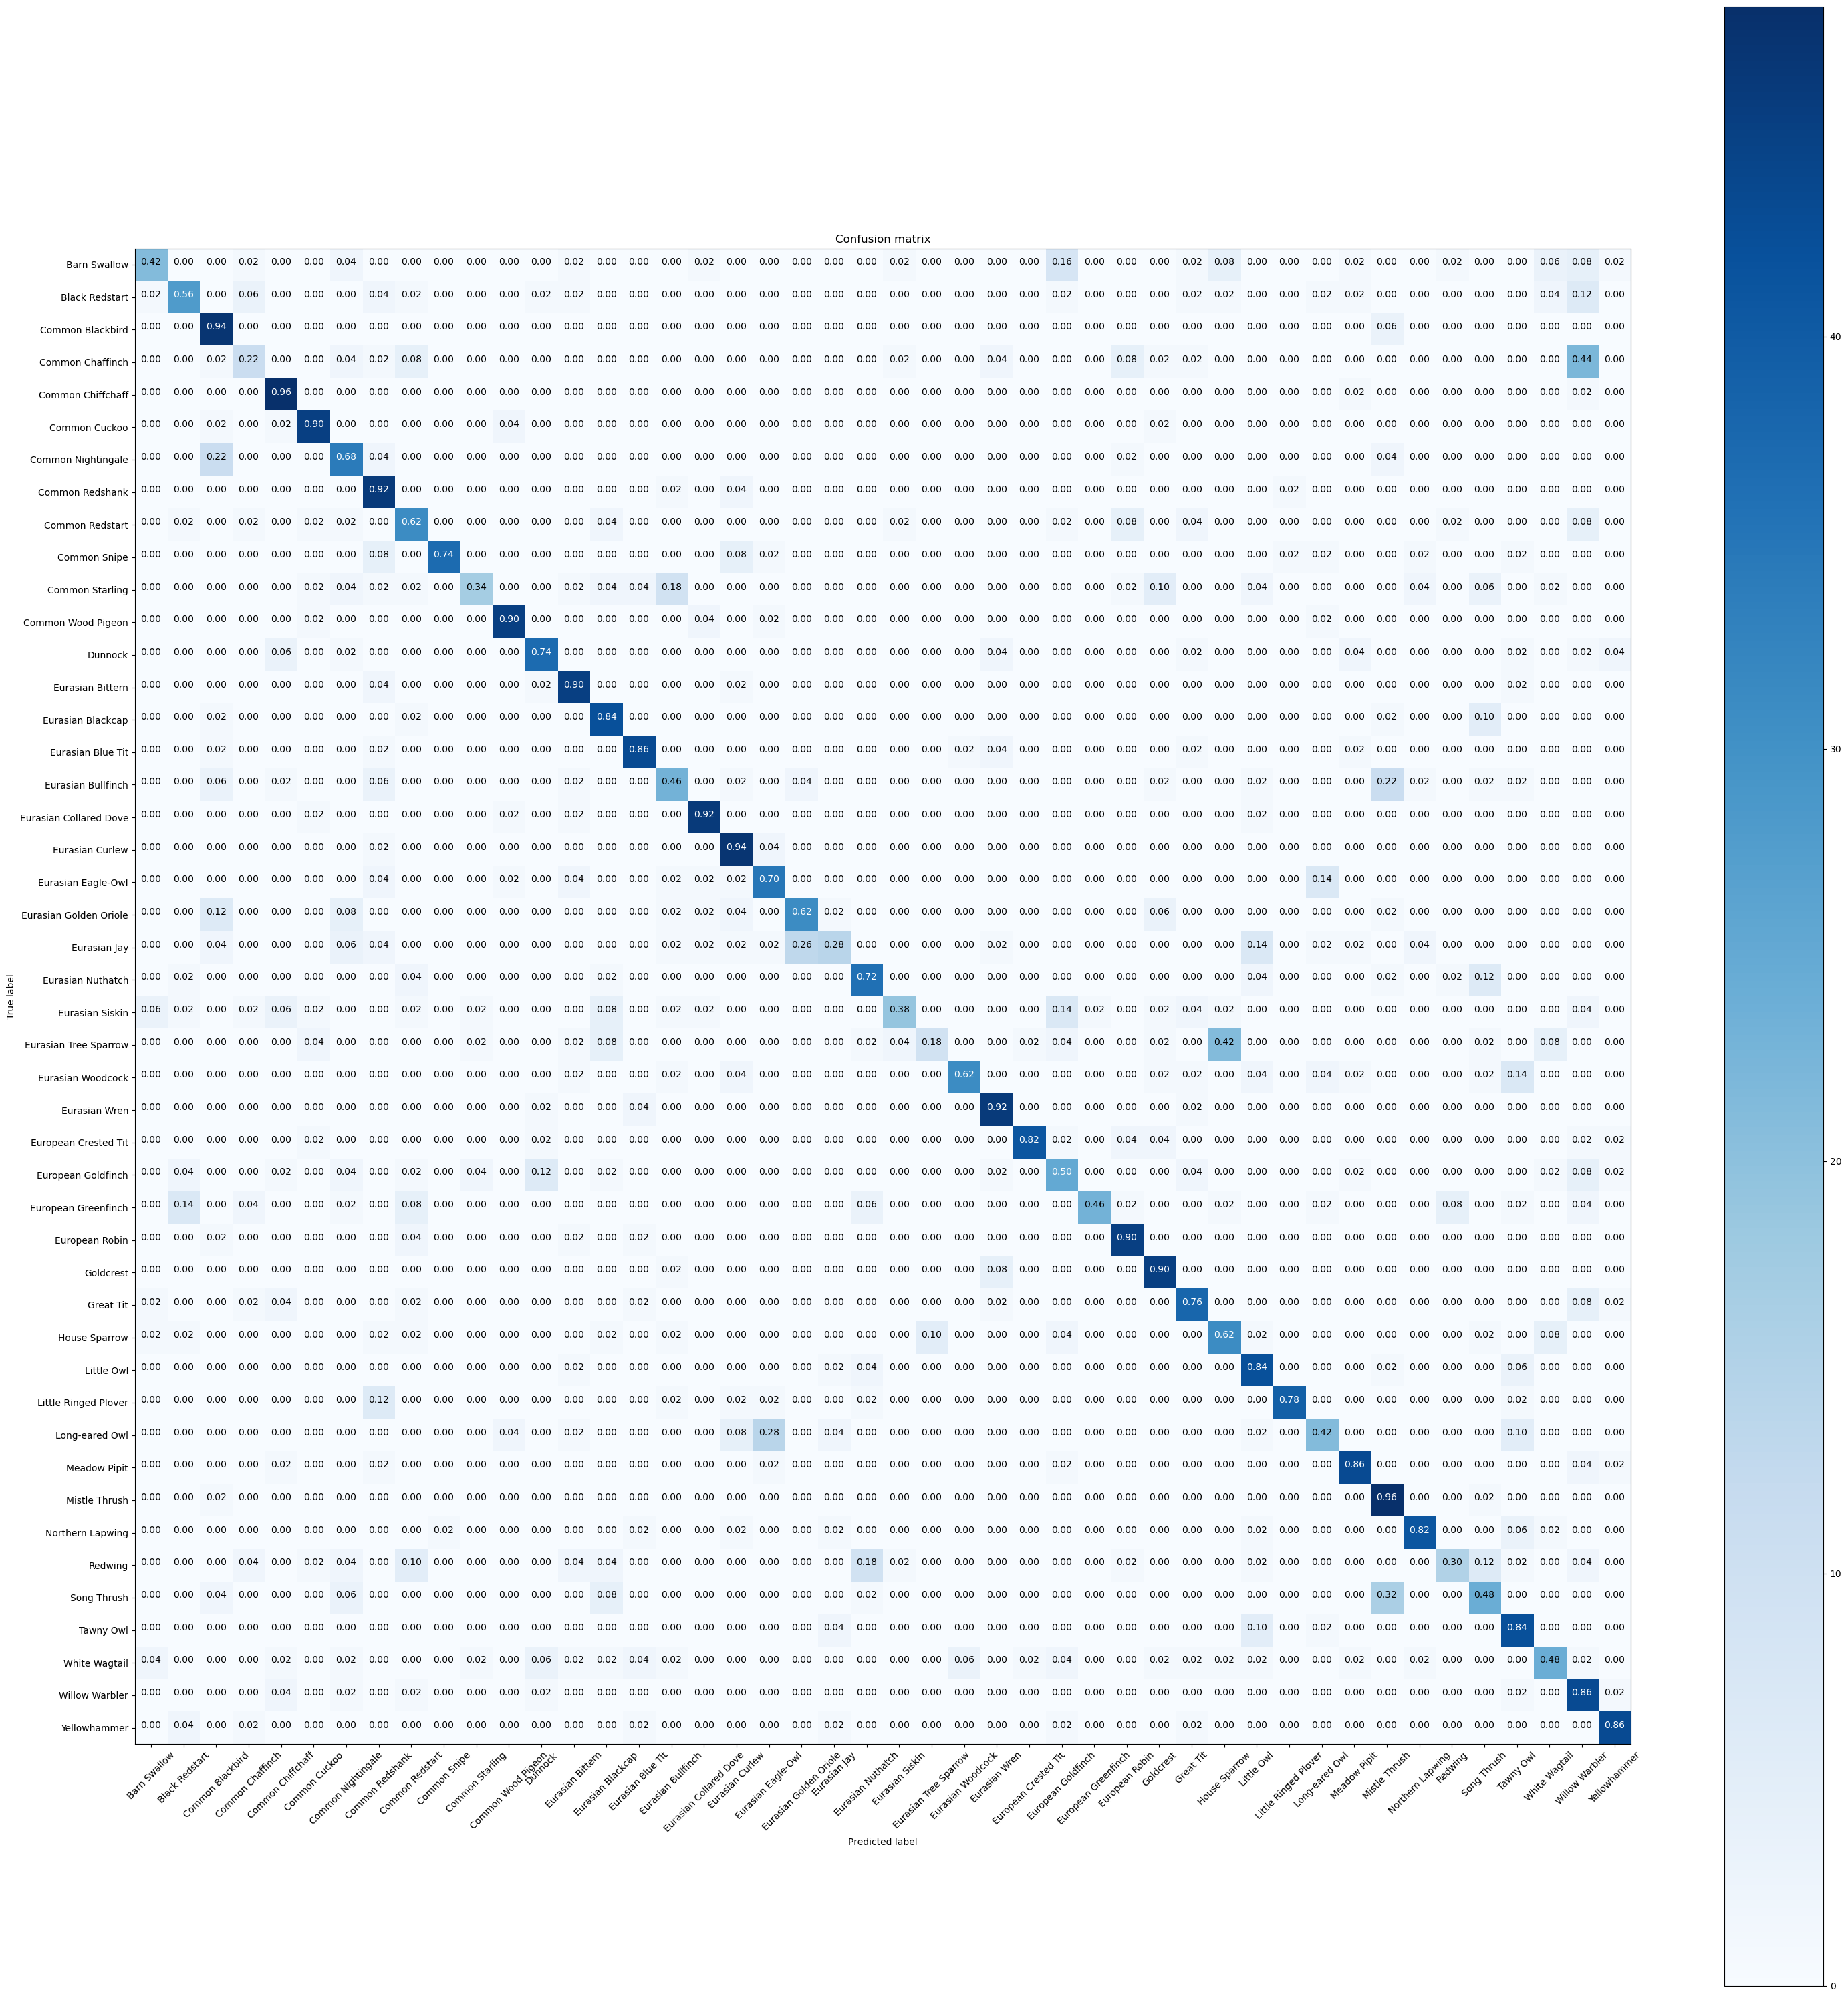

In [48]:
import itertools
plt.figure(figsize = (30, 30))
plot_confusion_matrix(confusion_mtx, cfg.names,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

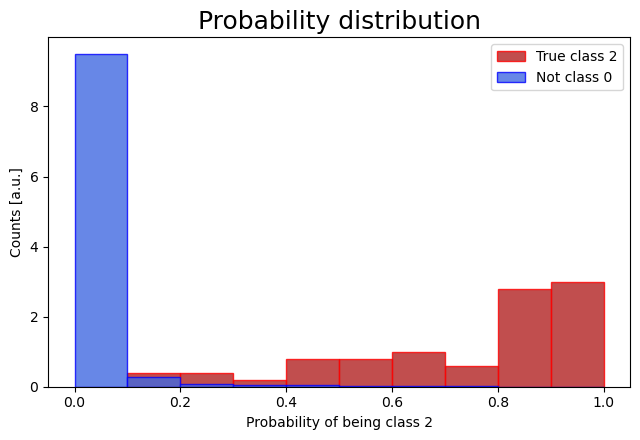

In [105]:
plt.figure(figsize=(6.5, 4.5))

classnr = 2

_, bins, _ = plt.hist(preds[:, classnr][trues[:, classnr] == 1], bins = 10, color = "firebrick", edgecolor = "r", range = [0, 1], density = True,
                          label = f"True class {classnr}", alpha = .8)
plt.hist(preds[:, classnr][trues[:, classnr] != 1], bins = bins, color = "royalblue", edgecolor = "b", density = True, label = "Not class 0", alpha = .8)
#plt.yscale("log")
plt.xlabel(f"Probability of being class {classnr}")
plt.ylabel("Counts [a.u.]")
plt.title("Probability distribution", fontsize = 18)
plt.legend()
plt.tight_layout()

In [106]:
print(len(preds_class[preds_class == true_label])/len(preds_class))

0.69


In [6]:
def compute_spec(filepath, sr=cfg.sr, duration=cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio, sr = librosa.load(filepath, sr = sr)
    # randomly pad clip if shorter
    if len(audio) < duration*sr:
        _ = np.zeros(duration*sr)
        rand_idx = np.random.randint(0, duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmin = 0, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

In [8]:
file = "../../data/own_recordings/Vogel_Terasse.mp3"

In [13]:
spec = compute_spec(file)
audio, sr = librosa.load(file, sr = cfg.sr)

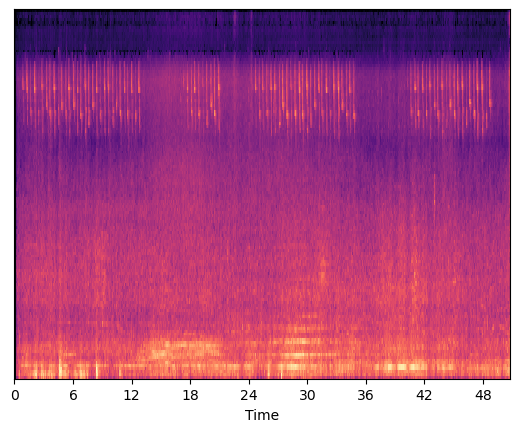

In [10]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

In [16]:
Audio(audio, rate = sr)

In [20]:
def predict_spec(spec, model):
    slices = []
    spec_length = spec.shape[1]
    for i in range(spec_length//cfg.input_dim[1]):
        slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
    if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration:
        # consider last slice, only if it is longer than the shortest clips in the dataset 
        slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
    
    preds = model.predict(np.expand_dims(np.array(slices), axis = -1))
    return np.mean(preds, axis = 0) # return mean prediction

In [30]:
np.argsort(predict_spec(spec, model))

1/1 [==============================] - 0s 25ms/step


array([11, 22, 17, 30, 35, 29,  7, 14,  8, 25, 26,  9, 27,  5, 41, 40, 38,
       15, 31, 24,  1, 36,  3, 18, 23,  2, 19, 34, 33, 42, 39, 32,  0, 44,
       21, 20, 28, 45, 10,  6, 16, 13, 12,  4, 43, 37])

In [37]:
cfg.label2name[16]

'Eurasian Bullfinch'